# App for analyzing GECCO runs for single site over time

1. Combine several gecco outputs with .
2. Visualize BGCs evolution over time.
4. Quantify difference

Note: Sending GECCO jobs to Galaxy is part of another separate NB, `bgc_run_gecco_job.ipynb`.

## Platform dependent part
- Resolve platform setup
- the difference to local imports should be resolved by setting the VRE packages well

In [330]:
import os
import sys
import logging
import psutil
from IPython import get_ipython

logger = logging.getLogger(name="GECCO analyze over time")

if 'google.colab' in str(get_ipython()):
    print('Setting Google colab, you will need a ngrok account to make the dashboard display over the tunnel. \
    https://ngrok.com/')
    # clone the momics-demos repository to use it to load data
    try:
        os.system('git clone https://github.com/palec87/momics-demos.git')
        logger.info(f"Repository cloned")
    except OSError as e:
        logger.info(f"An error occurred while cloning the repository: {e}")

    sys.path.insert(0,'/content/momics-demos')

    # this step takes time beacause of many dependencies
    os.system('pip install momics@git+https://github.com/emo-bon/marine-omics-methods.git@main')

elif psutil.users() == []:
    logger.info("Binder")

else:
    logger.info("Local server")

from momics.utils import init_setup, get_notebook_environment, memory_load, reconfig_logger
init_setup()

# Set up logging
reconfig_logger()

# Determine the notebook environment
env = get_notebook_environment()
logger.info(f"Environment: {env}")

INFO | GECCO analyze over time | Local server
INFO | root | Logging.basicConfig completed successfully
INFO | GECCO analyze over time | Environment: vscode


Local IPython, nothing else to install


## Imports

In [331]:
# This needs to be repeated here for the Pannel dashboard to work, WEIRD
# TODO: report as possible bug
import sys
import os
import io

# import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
import panel as pn

# Import
# import bioblend.galaxy as g  # BioBlend is a Python library, wrapping the functionality of Galaxy and CloudMan APIs
# from bioblend.galaxy import GalaxyInstance

# All low level functions are imported from the momics package
import momics.diversity as div
import momics.plotting as pl
from momics.panel_utils import serve_app, close_server
from momics.loader import bytes_to_df

### User settings

In [332]:
DEBUG = True  # enable stdout logging

## Loading and setup

In [333]:
if 'google.colab' in str(get_ipython()):
    root_folder = os.path.abspath(os.path.join('/content/momics-demos'))
else:
    root_folder = os.path.abspath(os.path.join('../'))

assets_folder = os.path.join(root_folder, 'assets')

## testing everything up

### combine gecco results tables

In [334]:
pn.extension('tabulator')
upload_local = pn.widgets.FileInput(
    multiple=True,
    accept='.tsv',
)

In [335]:
upload_local

BokehModel(combine_events=True, render_bundle={'docs_json': {'23a25a94-6cfa-4937-9141-a2e06f16d175': {'version…

In [392]:
def bgc_tables_dict(tsv_data: list, tsv_names: list):
    """
    Combine multiple BGC tables into a single DataFrame.

    Args:
        tvs_files (list): List of file paths to the TVS files.

    Returns:
        pd.DataFrame: Combined DataFrame with all BGC data.
    """
    tables_dict = {}
    for i, data in enumerate(tsv_data):
        try:
            df = bytes_to_df(data)
            tables_dict[tsv_names[i]] = df
        except Exception as e:
            logger.error(f"Error reading file {data}: {e}")
            continue
    return tables_dict


# TODO: I need to add metadata somehow
## method to merge tracker and shipments data
def merge_tracker_metadata(df_tracker):
    BATCH1_RUN_INFO_PATH = (
        "https://raw.githubusercontent.com/emo-bon/sequencing-data/main/shipment/"
        "batch-001/run-information-batch-001.csv"
    )
    BATCH2_RUN_INFO_PATH = (
        "https://raw.githubusercontent.com/emo-bon/sequencing-data/main/shipment/"
        "batch-002/run-information-batch-002.csv"
    )
    df = pd.read_csv(BATCH1_RUN_INFO_PATH)
    df1 = pd.read_csv(BATCH2_RUN_INFO_PATH)
    df = pd.concat([df, df1])
    print(len(df))

    # select only batch 1 and 2 from tracker data
    df_tracker = df_tracker[df_tracker['batch'].isin(['001', '002'])]

    # merge with tracker data on ref_code
    df = pd.merge(df, df_tracker, on='ref_code', how='inner')

    # split the sequenced tables
    df_discarded = df[df['lib_reads_seqd'].isnull()]
    df1 = df[~df['lib_reads_seqd'].isnull()]

    # deliver only filters and sediment samples, no blanks
    df_to_deliver = df1[df1['sample_type'].isin(['filters', 'sediment'])].reset_index(drop=True)
    #drop columns
    df_to_deliver.drop(columns='reads_name_y', inplace=True)
    df_to_deliver.rename(columns={'reads_name_x': 'reads_name'}, inplace=True)
    return df_to_deliver, df_discarded

def combine_metadata():
    url_metadata = "https://raw.githubusercontent.com/emo-bon/emo-bon-data-validation/refs/heads/main/validated-data/Batch1and2_combined_logsheets_2024-11-12.csv"
    url_tracker = "https://raw.githubusercontent.com/emo-bon/momics-demos/refs/heads/main/wf0_landing_page/emobon_sequencing_master.csv"

    df_metadata = pd.read_csv(url_metadata ,index_col=0)
    df_tracker = pd.read_csv(url_tracker ,index_col=0)
    df_to_deliver, _ = merge_tracker_metadata(df_tracker)
    assert len(df_to_deliver) == 181, "Number of samples in the metadata is not correct"

    mapper = df_to_deliver[['ref_code', 'source_mat_id', 'reads_name']]
    mapper['reads_name_short'] = mapper['reads_name'].str.split('_').str[-1]

    df_full = mapper.merge(df_metadata, on='ref_code', how='inner')
    assert len(df_full) == 181, "Number of samples in the metadata is not correct"
    return df_full


In [393]:
df_metadata = combine_metadata()

227


/tmp/ipykernel_39337/3273552159.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapper['reads_name_short'] = mapper['reads_name'].str.split('_').str[-1]


In [413]:
df_metadata.columns

Index(['ref_code', 'source_mat_id', 'reads_name', 'reads_name_short',
       'source_mat_id_orig', 'samp_description', 'tax_id', 'scientific_name',
       'investigation_type', 'env_material',
       ...
       'silicate_method', 'sulfate', 'sulfate_method', 'sulfide',
       'sulfide_method', 'turbidity', 'turbidity_method', 'water_current',
       'water_current_method', 'env_package'],
      dtype='object', length=116)

In [394]:
df_metadata[df_metadata['reads_name_short'] == 'HCFCYDSX5.UDI129']['collection_date'].values.tolist()[0]

'2021-10-22'

In [395]:
upload_local.filename

['HCFCYDSX5.UDI129_final.contigs.clusters.tsv',
 'HCFCYDSX5.UDI130_final.contigs.clusters.tsv',
 'HCFCYDSX5.UDI131_final.contigs.clusters.tsv',
 'HCFCYDSX5.UDI132_final.contigs.clusters.tsv',
 'HMNJKDSX3.UDI234_final.contigs.clusters.tsv',
 'HMNJKDSX3.UDI236_final.contigs.clusters.tsv',
 'HMNJKDSX3.UDI246_final.contigs.clusters.tsv',
 'HMNJKDSX3.UDI250_final.contigs.clusters.tsv',
 'HVWGWDSX5.UDI102_final.contigs.clusters.tsv',
 'HVWGWDSX5.UDI103_final.contigs.clusters.tsv',
 'HVWGWDSX5.UDI115_final.contigs.clusters.tsv',
 'HVWGWDSX5.UDI127_final.contigs.clusters.tsv',
 'HVWGWDSX5.UDI150_final.contigs.clusters.tsv',
 'HVWGWDSX5.UDI162_final.contigs.clusters.tsv',
 'HVWGWDSX5.UDI174_final.contigs.clusters.tsv',
 'HVWGWDSX5.UDI186_final.contigs.clusters.tsv']

In [396]:
upload_local.value

[b'sequence_id\tcluster_id\tstart\tend\taverage_p\tmax_p\ttype\talkaloid_probability\tnrp_probability\tpolyketide_probability\tripp_probability\tsaccharide_probability\tterpene_probability\tproteins\tdomains\nk141_1048287\tk141_1048287_cluster_1\t129\t3952\t0.9576711133347096\t0.9634287616303627\tTerpene\t0.03307300834554183\t0.1325449871255493\t0.1561327244259112\t0.12238350526201303\t0.010000000000000009\t0.5119459228619581\tk141_1048287_1;k141_1048287_2;k141_1048287_3\tPF00432;PF01839;PF01839;PF01839;PF13243;PF13249;PF14104\nk141_1056062\tk141_1056062_cluster_1\t2674\t6382\t0.9994303702764117\t0.99994440507631\tUnknown\t0.07743685894095931\t0.12113784596336108\t0.1310082719210669\t0.11305416847424932\t0.27\t0.1925965590021026\tk141_1056062_4;k141_1056062_5;k141_1056062_6\tPF00078;PF00098;PF17917;PF17919;PF17921\nk141_1065989\tk141_1065989_cluster_1\t2\t2703\t0.9285240294886559\t0.9320657838028591\tNRP\t0.028140484695933776\t0.7056596698632018\t0.12331252035854456\t0.0288344771127513

In [397]:
tables = bgc_tables_dict(upload_local.value, upload_local.filename)

In [398]:
tables.keys()

dict_keys(['HCFCYDSX5.UDI129_final.contigs.clusters.tsv', 'HCFCYDSX5.UDI130_final.contigs.clusters.tsv', 'HCFCYDSX5.UDI131_final.contigs.clusters.tsv', 'HCFCYDSX5.UDI132_final.contigs.clusters.tsv', 'HMNJKDSX3.UDI234_final.contigs.clusters.tsv', 'HMNJKDSX3.UDI236_final.contigs.clusters.tsv', 'HMNJKDSX3.UDI246_final.contigs.clusters.tsv', 'HMNJKDSX3.UDI250_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI102_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI103_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI115_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI127_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI150_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI162_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI174_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI186_final.contigs.clusters.tsv'])

In [417]:
for key in tables.keys():
    date = df_metadata[df_metadata['reads_name_short'] == key.split('_')[0]]['collection_date'].values.tolist()[0]
    material = df_metadata[df_metadata['reads_name_short'] == key.split('_')[0]]['env_package'].values.tolist()[0]
    replicate = df_metadata[df_metadata['reads_name_short'] == key.split('_')[0]]['replicate'].values.tolist()[0]
    print(key, date, replicate, material)

HCFCYDSX5.UDI129_final.contigs.clusters.tsv 2021-10-22 1 soft_sediment
HCFCYDSX5.UDI130_final.contigs.clusters.tsv 2021-10-22 2 soft_sediment
HCFCYDSX5.UDI131_final.contigs.clusters.tsv 2021-12-20 1 soft_sediment
HCFCYDSX5.UDI132_final.contigs.clusters.tsv 2021-12-20 2 soft_sediment
HMNJKDSX3.UDI234_final.contigs.clusters.tsv 2021-08-05 1 water_column
HMNJKDSX3.UDI236_final.contigs.clusters.tsv 2021-08-05 1 soft_sediment
HMNJKDSX3.UDI246_final.contigs.clusters.tsv 2021-08-05 2 water_column
HMNJKDSX3.UDI250_final.contigs.clusters.tsv 2021-08-05 2 soft_sediment
HVWGWDSX5.UDI102_final.contigs.clusters.tsv 2021-10-22 1 water_column
HVWGWDSX5.UDI103_final.contigs.clusters.tsv 2021-12-20 2 water_column
HVWGWDSX5.UDI115_final.contigs.clusters.tsv 2021-12-20 1 water_column
HVWGWDSX5.UDI127_final.contigs.clusters.tsv 2021-12-20 2 water_column
HVWGWDSX5.UDI150_final.contigs.clusters.tsv 2021-10-22 2 water_column
HVWGWDSX5.UDI162_final.contigs.clusters.tsv 2021-10-22 1 water_column
HVWGWDSX5.UDI1

In [400]:
for key in tables.keys():
    date = df_metadata[df_metadata['reads_name_short'] == key.split('_')[0]]
    # display(date['replicate'])
    print(int(date['replicate'].values.tolist()[0]))

1
2
1
2
1
1
2
2
1
2
1
2
2
1
2
1


### analysis

## Single Graph construction

In [401]:
import matplotlib.pyplot as plt
import networkx as nx

In [402]:
def graph_nodes_edges(df, color_hash):
    nodes = []
    for i, row in df.iterrows():
        nodes.append(
            (
                row['cluster_id'],
                {'type': row['type'],
                'color': color_hash[row['type']],
                }
            ),
        )
    print(f"Number of nodes: {len(nodes)}")

    nodes_domains = []
    already_seen = set()
    for i, row in df.iterrows():
        domains = row['domains'].strip().split(';')
        for domain in domains:
            if domain not in already_seen:
                already_seen.add(domain)
                nodes_domains.append(
                    (
                        domain,
                        {'type': "domain_node",
                        'color': "grey",
                        }
                    ),
                )
            else:
                pass 

    assert len(nodes_domains) == len(already_seen), f"Number of nodes is not correct, {len(nodes_domains)} != {len(already_seen)}"
    print(f"Number of nodes from domains: {len(nodes_domains)}")

    edges = []

    for i, row in df.iterrows():
        lst_domains = list(set(row['domains'].strip().split(';')))
        assert len(lst_domains) == len(set(lst_domains)), f"Number of domains is not correct, {len(lst_domains)} != {len(set(lst_domains))}"
        for j in range(len(lst_domains)):
            # connect cluster ids to domains
            edges.append((row['cluster_id'], lst_domains[j]))

    print(f"Number of edges: {len(edges)}")
    return nodes, nodes_domains, edges

def generate_graph(nodes, nodes_domains, edges, collection_date):
    import networkx as nx
    G = nx.Graph(
        date = collection_date,
    )

    G.add_nodes_from(nodes)
    G.add_nodes_from(nodes_domains)
    G.add_edges_from(edges)

    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    return G


def plot_graph(G, color_hash):
    colors = [k[1]['color'] for k in G.nodes(data=True)]

    # drawing nodes and edges separately so we can capture collection for colobar
    pos = nx.spring_layout(G, k=0.2)
    # pos = nx.kamada_kawai_layout(G)
    # pos = nx.spiral_layout(G)
    ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=colors,
                                node_size=15,
                                alpha=0.5,
                                cmap=plt.cm.jet)
    # plt.colorbar(color_hash)
    plt.axis('off')
    plt.legend(
        handles=[plt.Line2D([0], [0], marker='o', color='w', label=k, markerfacecolor=v)
                for k, v in color_hash.items()],
        loc='upper left',
        bbox_to_anchor=(1, 1),
        title="BGC type",
    )
    plt.title(f"Collection date: {G.graph['date']}")
    plt.show()

from collections import Counter
def count_multiple_edges(edges):
    """
    Count appearances of the second position in the edge tuple and filter those with more than one occurrence.

    Args:
        edges (list): List of edge tuples.

    Returns:
        tuple: A tuple containing:
            - cnt_full (Counter): Full count of appearances.
            - cnt_multiple (dict): Filtered counts with more than one occurrence.
    """
    edge_counter = [e[1] for e in edges]
    cnt_full = Counter(edge_counter)

    # Filter those which have more than 1
    cnt_multiple = {k: v for k, v in cnt_full.items() if v > 1}
    cnt_multiple = dict(sorted(cnt_multiple.items(), key=lambda item: item[1], reverse=True))

    return cnt_full, cnt_multiple


def plot_domain_edges_counts(counts, title: str = "Domain counts"):
    # barplot
    plt.figure(figsize=(10, 5))
    plt.bar(counts.keys(), counts.values())
    plt.xticks(rotation=90)
    plt.xlabel('Domain')
    plt.ylabel('Count')
    plt.title('Domain Counts')
    plt.tight_layout()
    plt.title(title, )
    plt.show()

def create_graph_id(name: str):
    """
    Create a unique graph ID based on the collection date and replicate number.

    Returns:
        str: Unique graph ID.
    """
    graph_id = df_metadata[df_metadata['reads_name_short'] == name.split('_')[0]]['collection_date'].values.tolist()[0] + \
        '_repl_' + str(int(df_metadata[df_metadata['reads_name_short'] == name.split('_')[0]]['replicate'].values.tolist()[0]))
    return graph_id

In [403]:
color_hash = {
    'NRP': 'red',
    'PKS': 'blue',
    'RiPPs': 'darkgreen',
    'Terpene': 'brown',
    'Unknown': 'black',
    'Polyketide': 'purple',
    'NRP;Polyketide': 'orange',
    'RiPP': 'darkblue',
    'Saccharide': 'darkred',
    'domain': 'lightgrey',
}

In [404]:
print(tables.keys())

dict_keys(['HCFCYDSX5.UDI129_final.contigs.clusters.tsv', 'HCFCYDSX5.UDI130_final.contigs.clusters.tsv', 'HCFCYDSX5.UDI131_final.contigs.clusters.tsv', 'HCFCYDSX5.UDI132_final.contigs.clusters.tsv', 'HMNJKDSX3.UDI234_final.contigs.clusters.tsv', 'HMNJKDSX3.UDI236_final.contigs.clusters.tsv', 'HMNJKDSX3.UDI246_final.contigs.clusters.tsv', 'HMNJKDSX3.UDI250_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI102_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI103_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI115_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI127_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI150_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI162_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI174_final.contigs.clusters.tsv', 'HVWGWDSX5.UDI186_final.contigs.clusters.tsv'])


In [405]:
table_names = list(tables.keys())
df = tables[table_names[0]]
df.head()

sequence_id              cluster_id  start    end  average_p     max_p  \
0  k141_1048287  k141_1048287_cluster_1    129   3952   0.957671  0.963429   
1  k141_1056062  k141_1056062_cluster_1   2674   6382   0.999430  0.999944   
2  k141_1065989  k141_1065989_cluster_1      2   2703   0.928524  0.932066   
3  k141_1067118  k141_1067118_cluster_1     66  11014   0.940587  0.999159   
4  k141_1113628  k141_1113628_cluster_1      2   4104   0.952922  0.996064   

      type  alkaloid_probability  nrp_probability  polyketide_probability  \
0  Terpene              0.033073         0.132545                0.156133   
1  Unknown              0.077437         0.121138                0.131008   
2      NRP              0.028140         0.705660                0.123313   
3  Unknown              0.108911         0.074195                0.124557   
4  Unknown              0.030699         0.204059                0.297264   

   ripp_probability  saccharide_probability  terpene_probability  \
0          0.122384                    0.01             0.511946   
1          0.113054                    0.27             0.192597   
2          0.028834                    0.00             0.027847   
3          0.074153                    0.03             0.222321   
4          0.171291                    0.01             0.215222   

                                            proteins  \
0       k141_1048287_1;k141_1048287_2;k141_1048287_3   
1       k141_1056062_4;k141_1056062_5;k141_1056062_6   
2       k141_1065989_1;k141_1065989_2;k141_1065989_3   
3  k141_1067118_1;k141_1067118_2;k141_1067118_3;k...   
4  k141_1113628_1;k141_1113628_2;k141_1113628_3;k...   

                                             domains  
0  PF00432;PF01839;PF01839;PF01839;PF13243;PF1324...  
1            PF00078;PF00098;PF17917;PF17919;PF17921  
2                    PF00550;PF00668;PF03781;PF03781  
3  PF00067;PF00494;PF00501;PF00512;PF01209;PF0122...  
4                            PF00027;PF01636;PF17914

Number of nodes: 65
Number of nodes from domains: 137
Number of edges: 481
Number of nodes: 202
Number of edges: 481


/home/david-palecek/miniforge3/envs/momics-demos/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


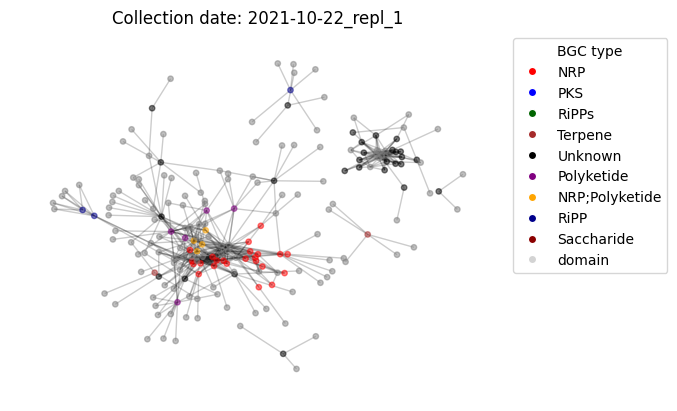

In [406]:

# over all
nodes, nodes_domains, edges = graph_nodes_edges(df, color_hash)

# contitutes date nad replicate number to make it unique
graph_id = create_graph_id(table_names[0])
G = generate_graph(nodes, nodes_domains, edges, graph_id)
plot_graph(G, color_hash)

In [407]:
cnt_full, cnt_multiple = count_multiple_edges(edges)

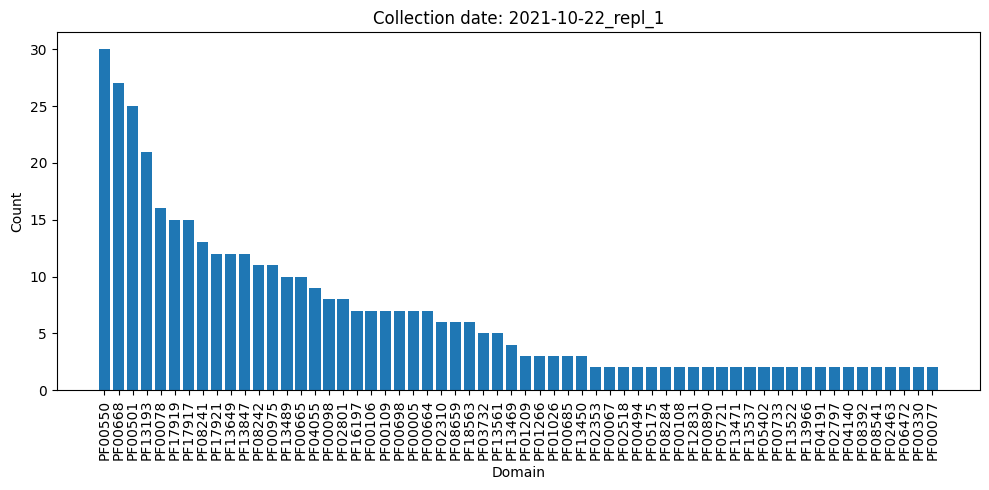

In [408]:
plot_domain_edges_counts(cnt_multiple, f"Collection date: {G.graph['date']}")

## SPlit betwen sediment and water column
- order by date

In [433]:
def get_meta_for_loop(tables, df_metadata, package='water_column'):
    """
    Get metadata for the loop.

    Args:
        tables (dict): Dictionary of tables.
        package (str): Package name to filter.

    Returns:
        list: List of filtered tables.
    """
    filtered_names = []
    for i, (name, df) in enumerate(tables.items()):
        date = df_metadata[df_metadata['reads_name_short'] == name.split('_')[0]]['collection_date'].values.tolist()[0]
        material = df_metadata[df_metadata['reads_name_short'] == name.split('_')[0]]['env_package'].values.tolist()[0]
        replicate = df_metadata[df_metadata['reads_name_short'] == name.split('_')[0]]['replicate'].values.tolist()[0]
        if package == material:
            filtered_names.append((date, replicate, name, package))

    # sort by date and replicate
    filtered_names.sort(key=lambda x: (x[0], x[1]))
    # print(filtered_names)
    return filtered_names


In [440]:
water_tables = get_meta_for_loop(tables, df_metadata, package='water_column')
sediment_tables = get_meta_for_loop(tables, df_metadata, package='soft_sediment')
for k in water_tables:
    print(k)


('2021-08-05', '1', 'HMNJKDSX3.UDI234_final.contigs.clusters.tsv', 'water_column')
('2021-08-05', '2', 'HMNJKDSX3.UDI246_final.contigs.clusters.tsv', 'water_column')
('2021-10-22', '1', 'HVWGWDSX5.UDI102_final.contigs.clusters.tsv', 'water_column')
('2021-10-22', '1', 'HVWGWDSX5.UDI162_final.contigs.clusters.tsv', 'water_column')
('2021-10-22', '2', 'HVWGWDSX5.UDI150_final.contigs.clusters.tsv', 'water_column')
('2021-10-22', '2', 'HVWGWDSX5.UDI174_final.contigs.clusters.tsv', 'water_column')
('2021-12-20', '1', 'HVWGWDSX5.UDI115_final.contigs.clusters.tsv', 'water_column')
('2021-12-20', '1', 'HVWGWDSX5.UDI186_final.contigs.clusters.tsv', 'water_column')
('2021-12-20', '2', 'HVWGWDSX5.UDI103_final.contigs.clusters.tsv', 'water_column')
('2021-12-20', '2', 'HVWGWDSX5.UDI127_final.contigs.clusters.tsv', 'water_column')


In [441]:
# for i, (name, df) in enumerate(tables.items()):
#     display(df_metadata[df_metadata['reads_name_short'] == name.split('_')[0]])

Number of nodes: 83
Number of nodes from domains: 206
Number of edges: 520
Number of nodes: 289
Number of edges: 520


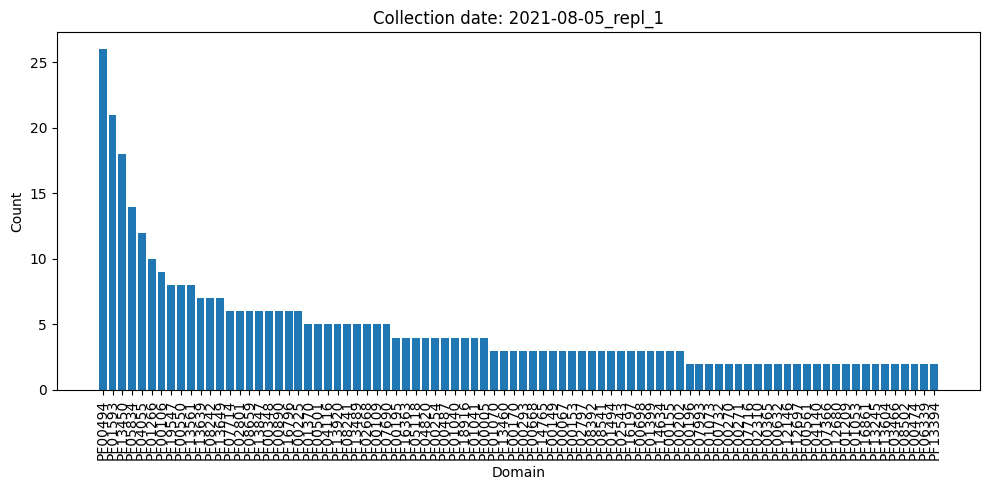

/home/david-palecek/miniforge3/envs/momics-demos/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


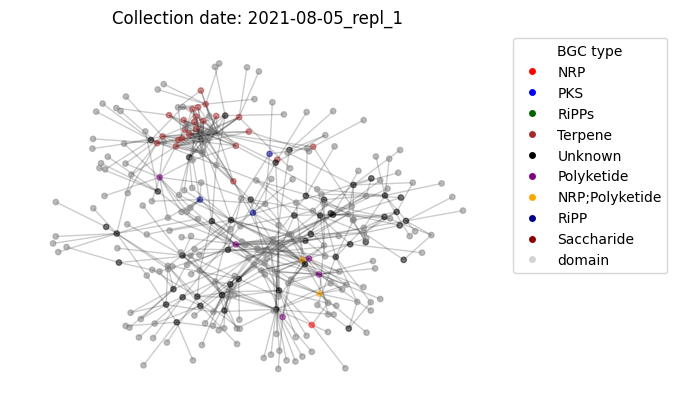

Number of nodes: 75
Number of nodes from domains: 194
Number of edges: 411
Number of nodes: 269
Number of edges: 411


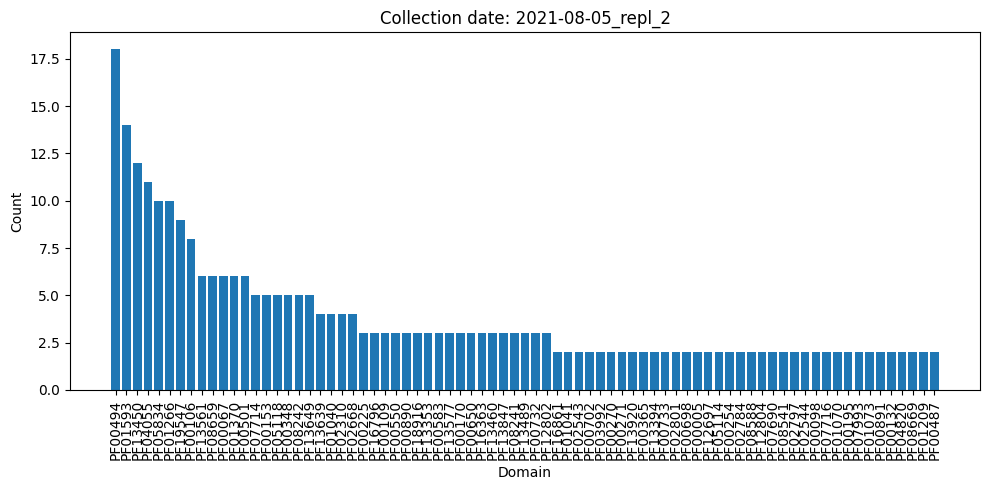

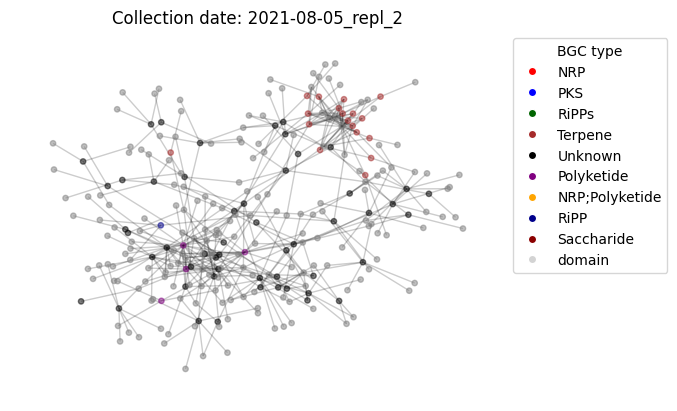

Number of nodes: 41
Number of nodes from domains: 110
Number of edges: 267
Number of nodes: 151
Number of edges: 267


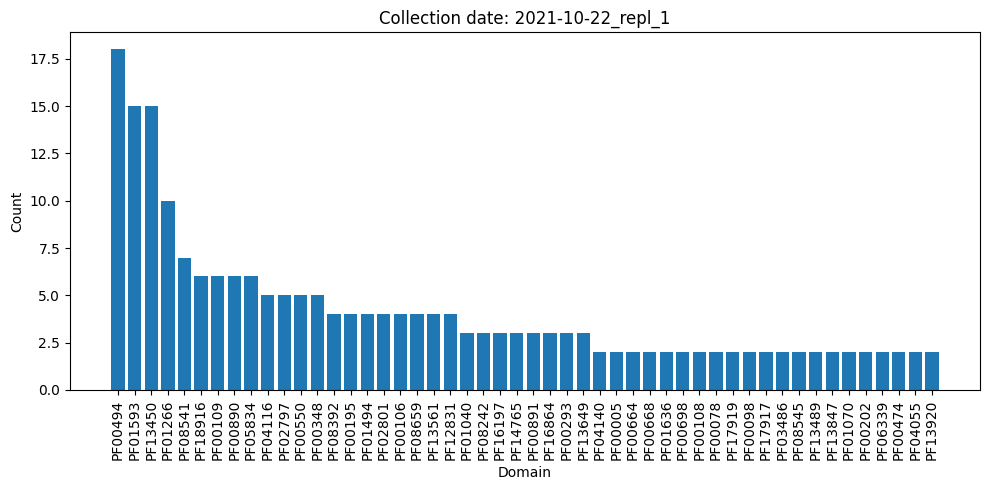

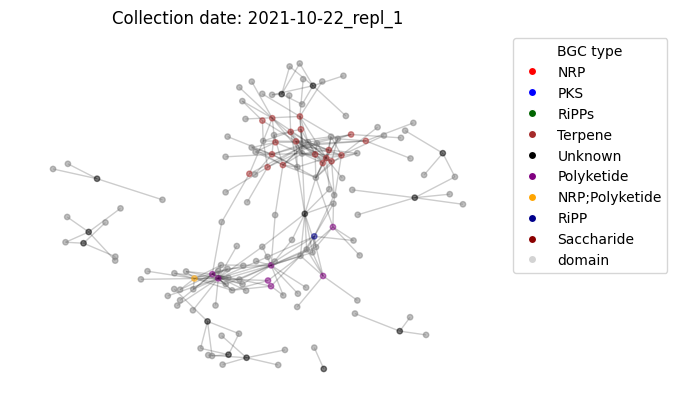

Number of nodes: 92
Number of nodes from domains: 222
Number of edges: 626
Number of nodes: 314
Number of edges: 626


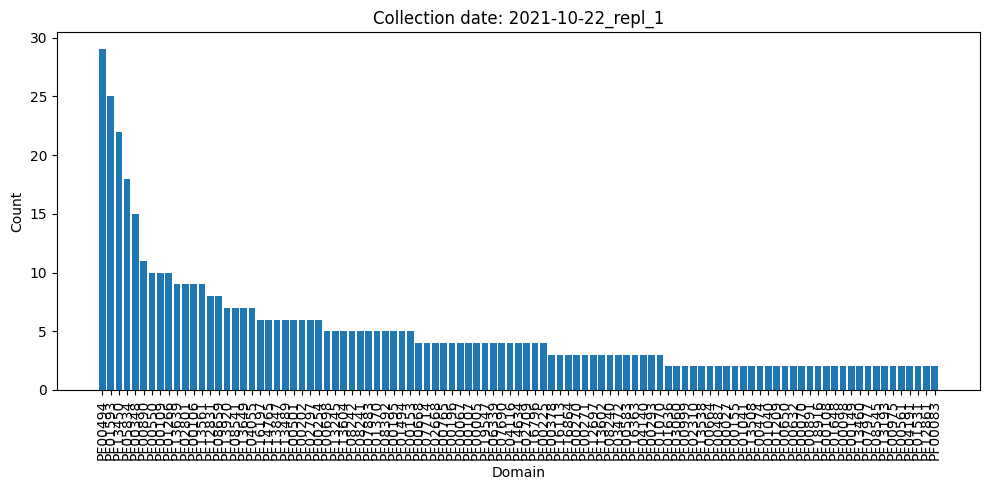

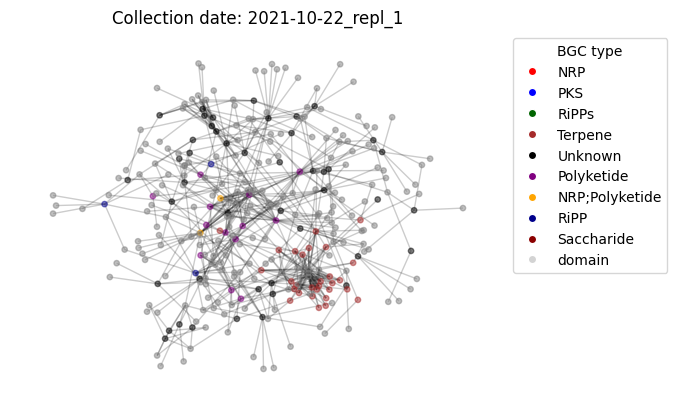

Number of nodes: 35
Number of nodes from domains: 91
Number of edges: 240
Number of nodes: 126
Number of edges: 240


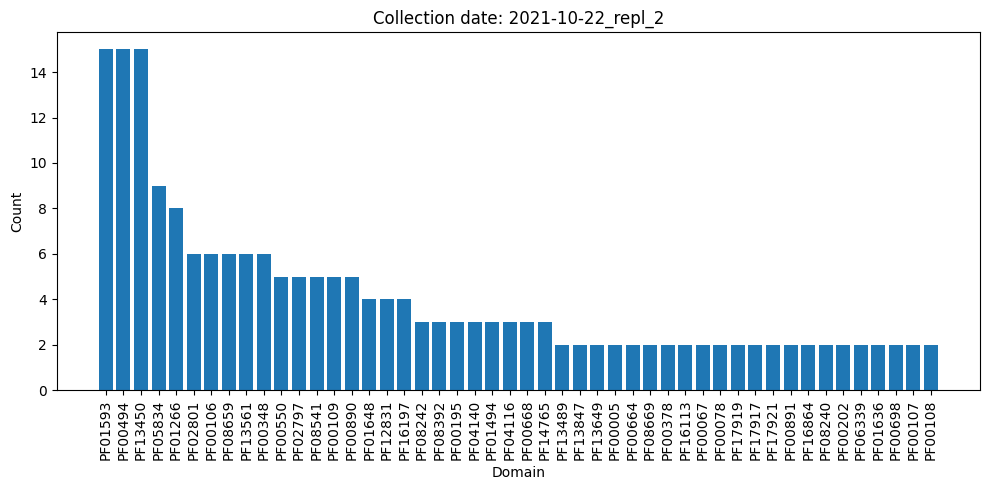

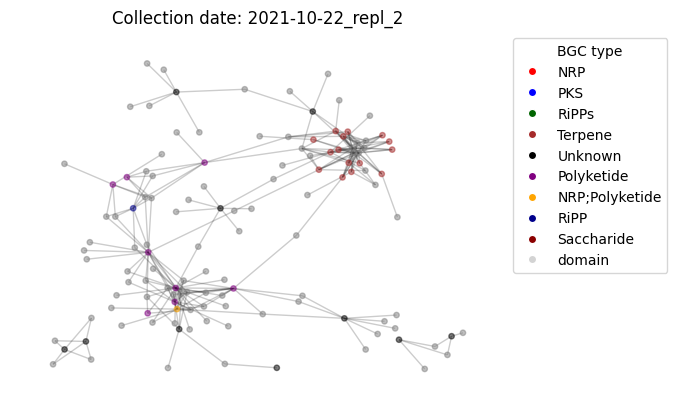

Number of nodes: 74
Number of nodes from domains: 189
Number of edges: 438
Number of nodes: 263
Number of edges: 438


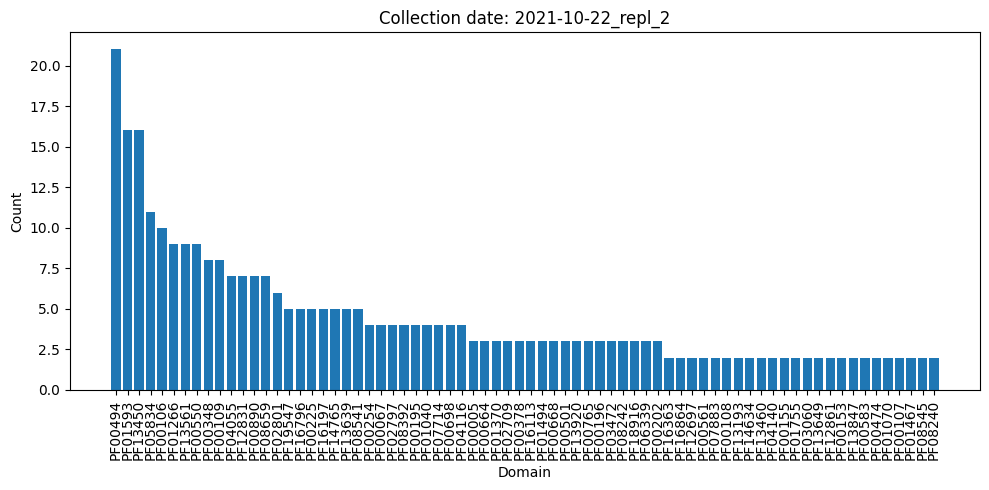

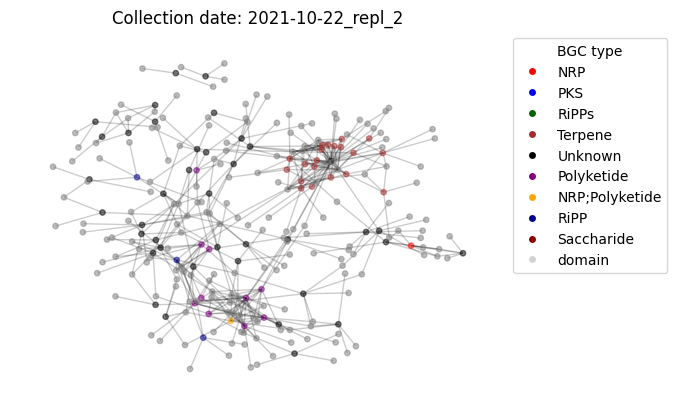

Number of nodes: 90
Number of nodes from domains: 186
Number of edges: 592
Number of nodes: 276
Number of edges: 592


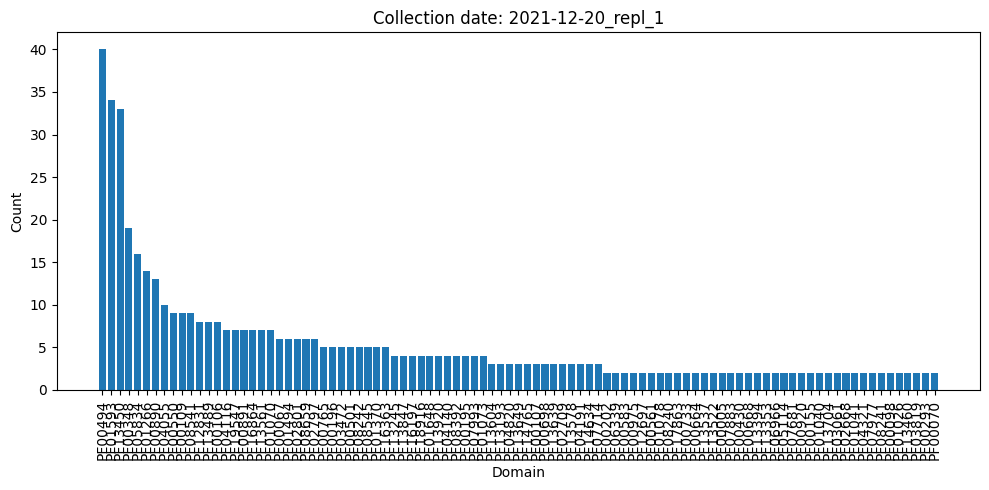

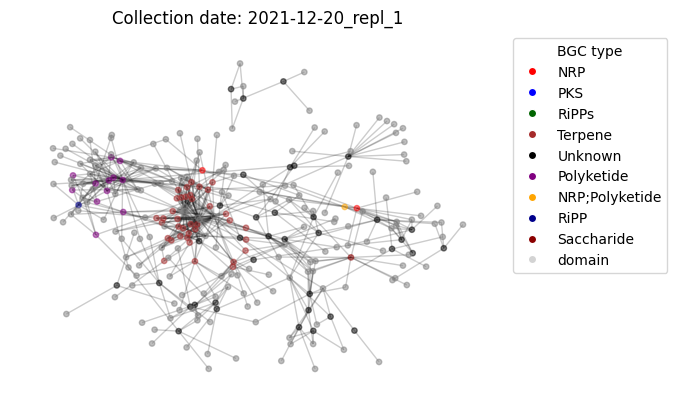

Number of nodes: 37
Number of nodes from domains: 107
Number of edges: 248
Number of nodes: 144
Number of edges: 248


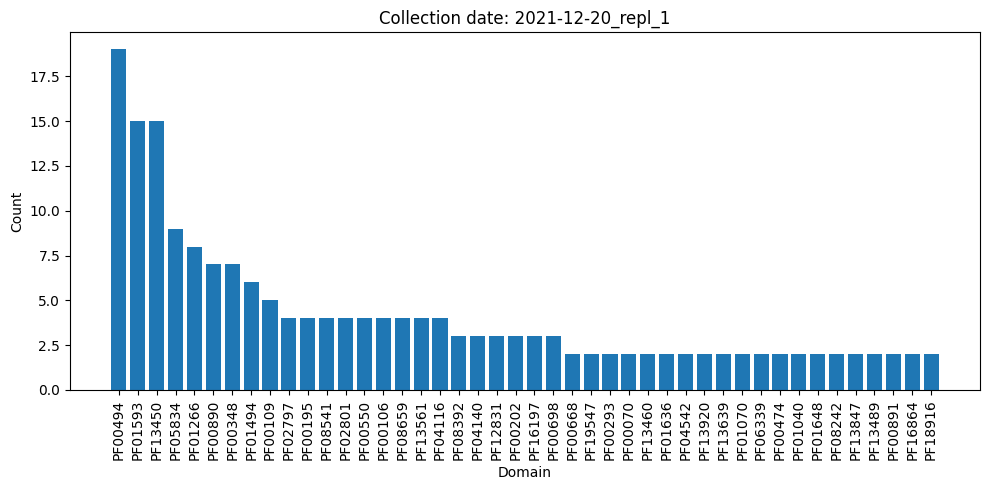

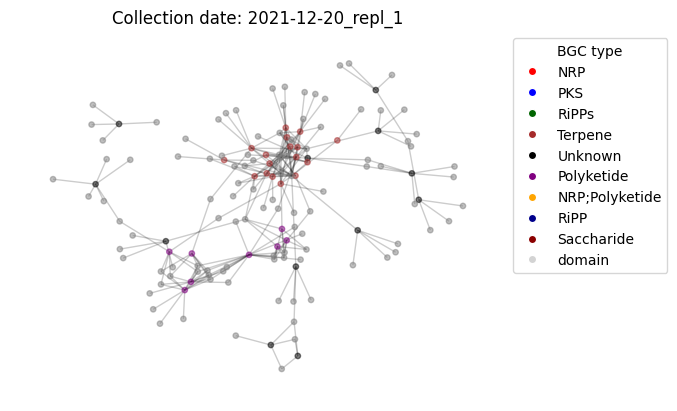

Number of nodes: 58
Number of nodes from domains: 142
Number of edges: 355
Number of nodes: 200
Number of edges: 355


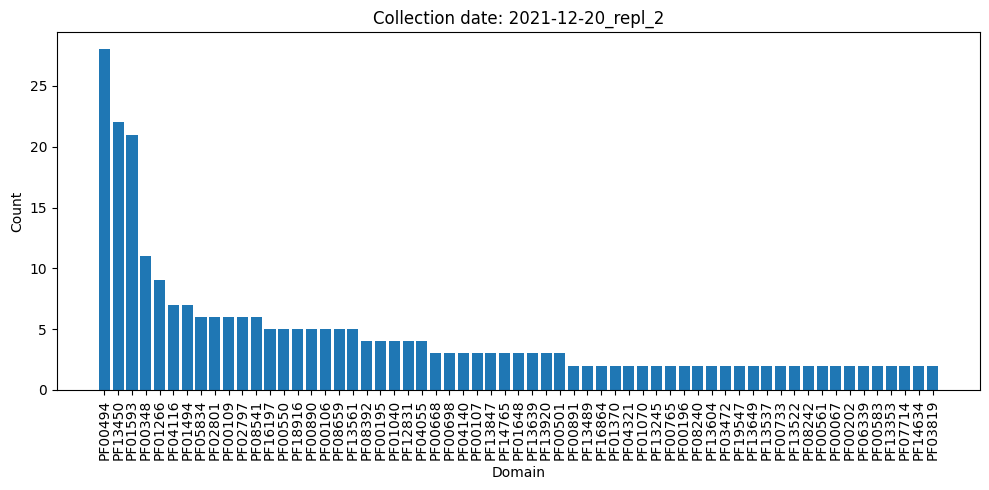

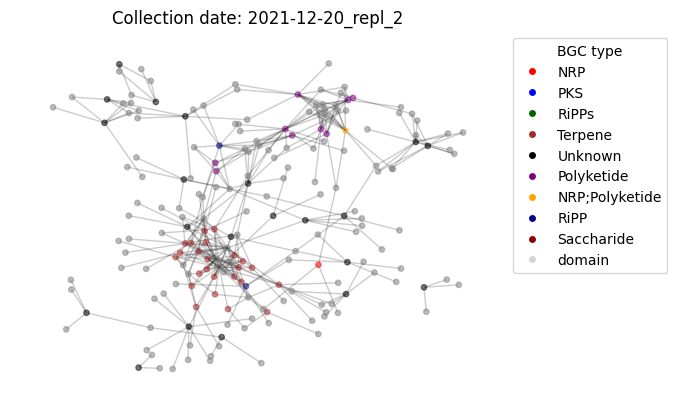

Number of nodes: 103
Number of nodes from domains: 200
Number of edges: 675
Number of nodes: 303
Number of edges: 675


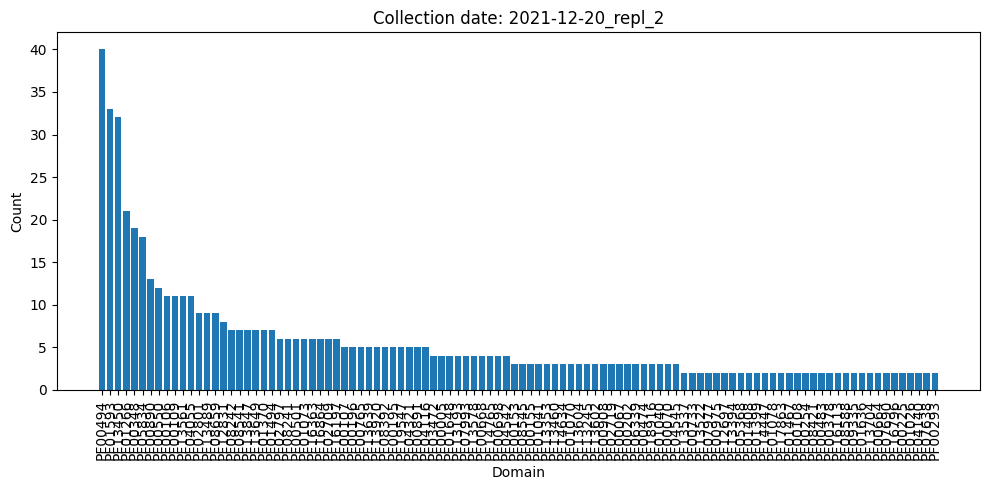

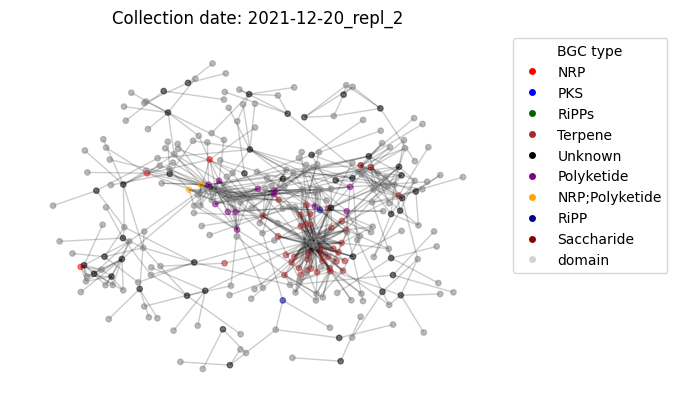

In [443]:
## water tables ordered
ALL_COUNTS_water = {}
all_ids_water = []
for item in water_tables:
    collection_date = create_graph_id(item[2])
    all_ids_water.append(collection_date)

    nodes, nodes_domains, edges = graph_nodes_edges(tables[item[2]], color_hash)
    G = generate_graph(nodes, nodes_domains, edges, collection_date)
    cnt_full, cnt_multiple = count_multiple_edges(edges)

    ALL_COUNTS_water[item[2]] = (cnt_full, cnt_multiple)

    plot_domain_edges_counts(cnt_multiple, f"Collection date: {G.graph['date']}")
    plot_graph(G, color_hash)

### Plot counts over time

In [444]:
# from ALL_COUNTS retrieve
from collections import defaultdict

counts_evolution = defaultdict(lambda: [0]*len(ALL_COUNTS_water.keys()))
for i, key in enumerate(ALL_COUNTS_water.keys()):
    cnt_full = ALL_COUNTS_water[key][0]
    for k, v in cnt_full.items():
        counts_evolution[k][i] = v

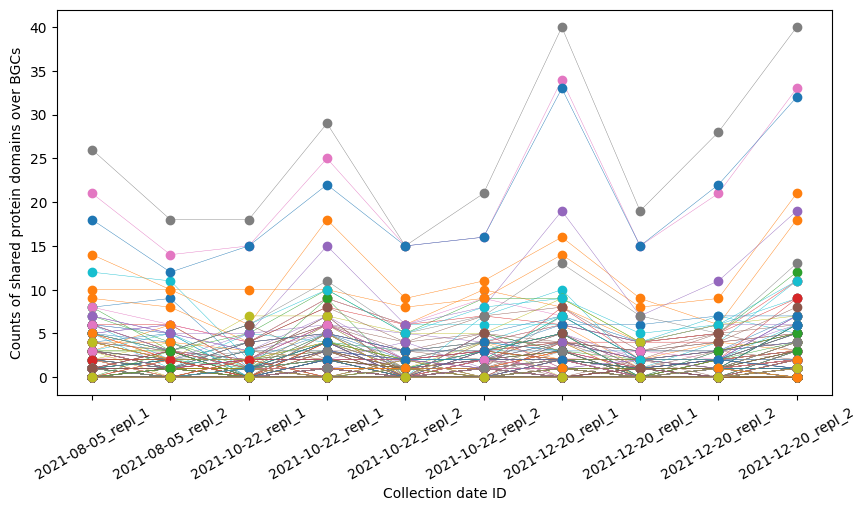

In [446]:
# plot counts evolution
plt.figure(figsize=(10, 5))
for i in counts_evolution.keys():
    plt.plot(counts_evolution[i], '-o', linewidth=0.3, label=i)

plt.xticks(range(len(all_ids_water)), all_ids_water, rotation=30)
plt.xlabel('Collection date ID')
plt.ylabel('Counts of shared protein domains over BGCs')
plt.show()

## Loop over sediments

Number of nodes: 8
Number of nodes from domains: 44
Number of edges: 52
Number of nodes: 52
Number of edges: 52


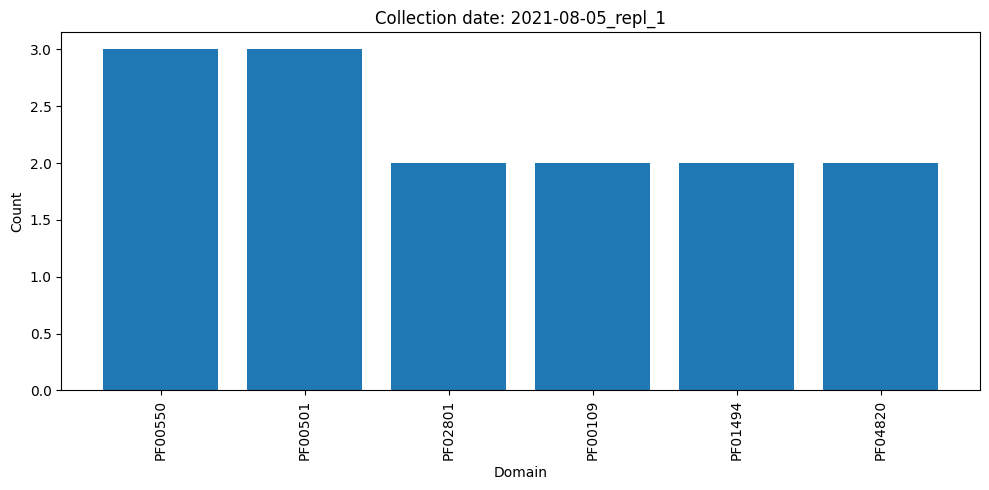

/home/david-palecek/miniforge3/envs/momics-demos/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


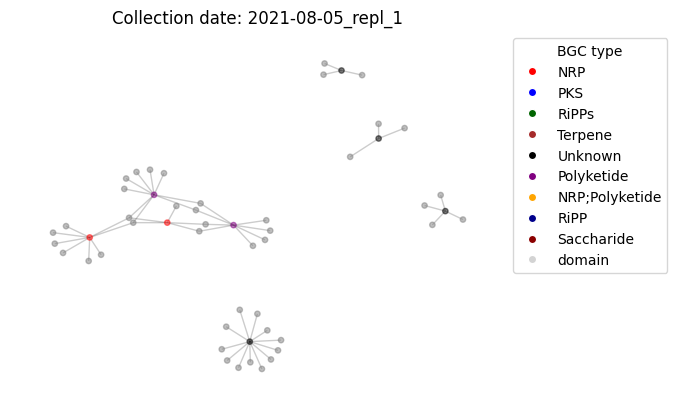

Number of nodes: 38
Number of nodes from domains: 139
Number of edges: 339
Number of nodes: 177
Number of edges: 339


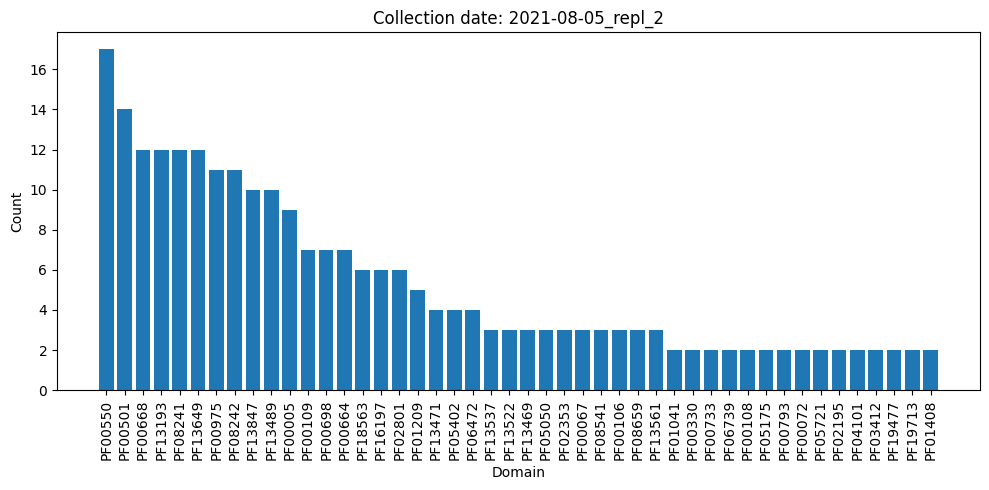

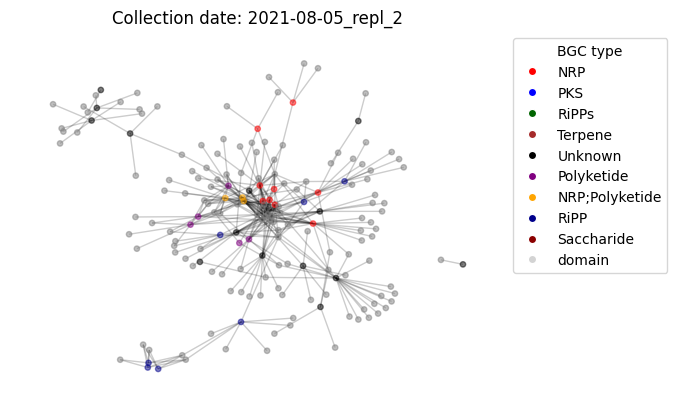

Number of nodes: 65
Number of nodes from domains: 137
Number of edges: 481
Number of nodes: 202
Number of edges: 481


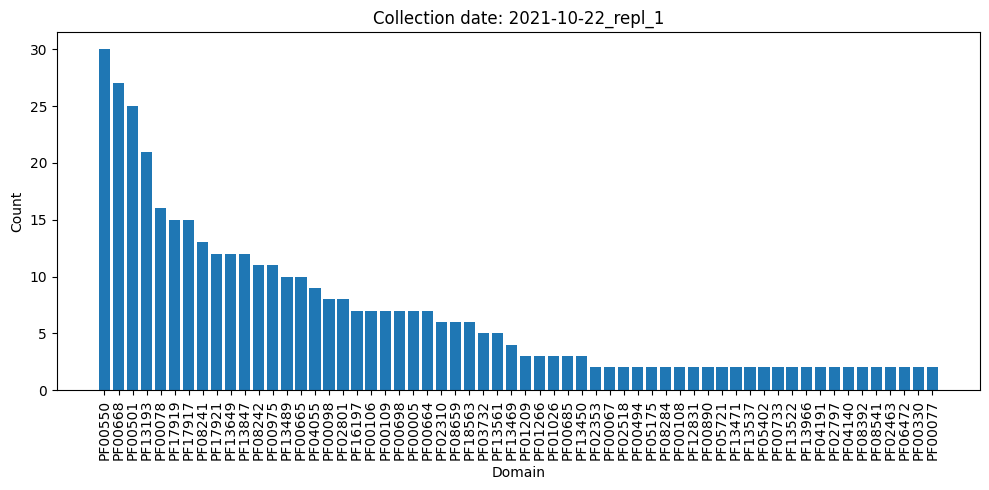

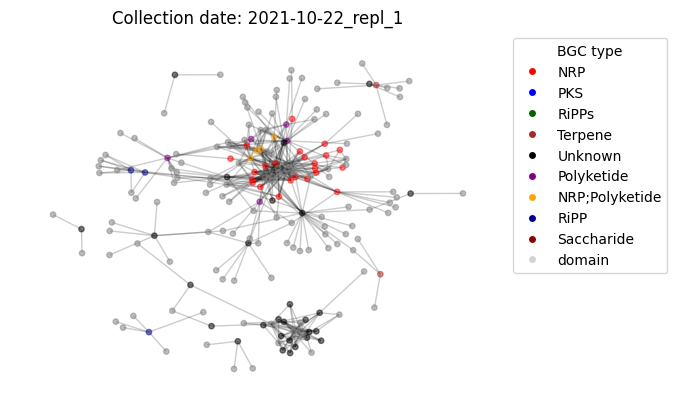

Number of nodes: 72
Number of nodes from domains: 183
Number of edges: 634
Number of nodes: 255
Number of edges: 634


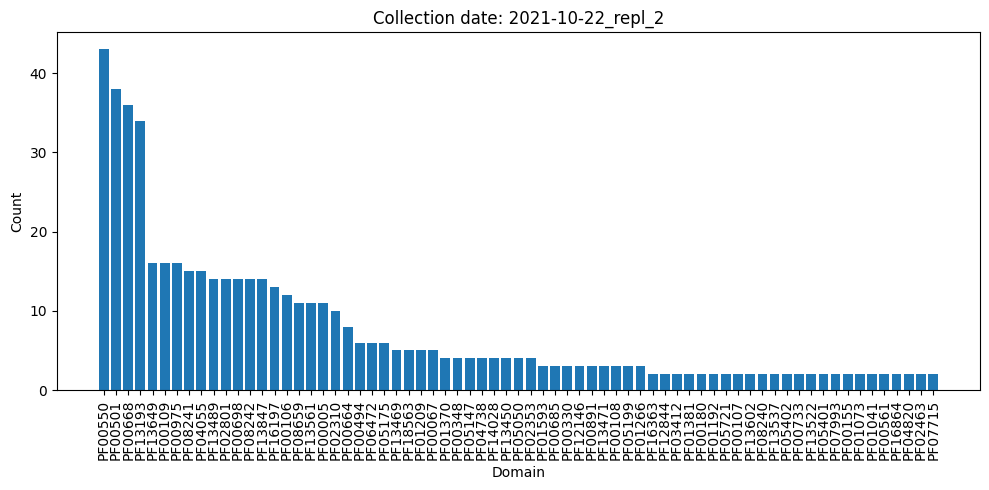

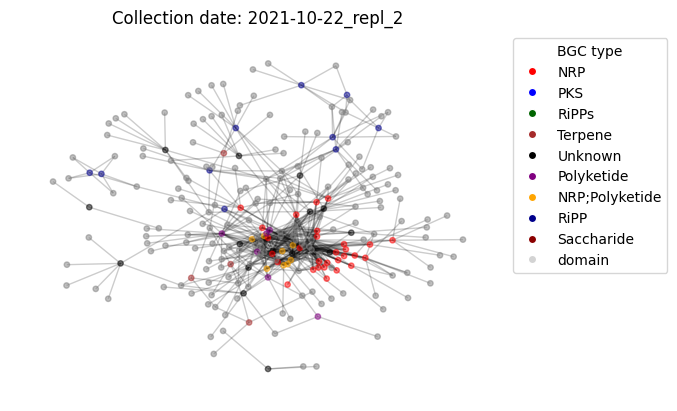

Number of nodes: 96
Number of nodes from domains: 264
Number of edges: 753
Number of nodes: 360
Number of edges: 753


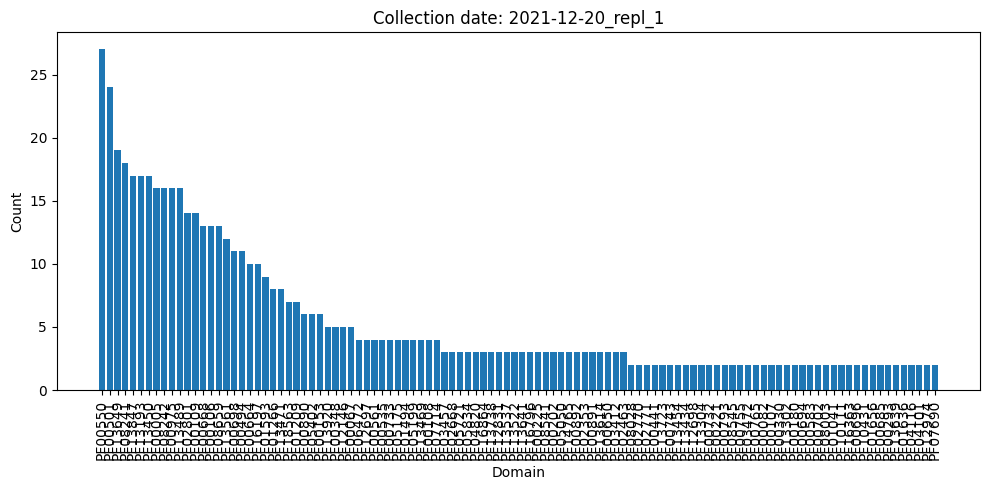

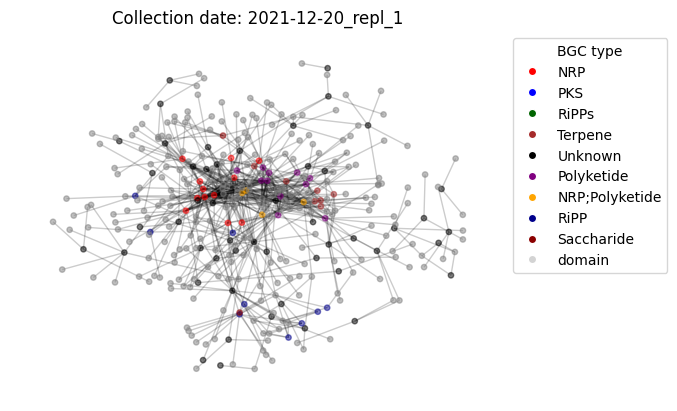

Number of nodes: 116
Number of nodes from domains: 275
Number of edges: 835
Number of nodes: 391
Number of edges: 835


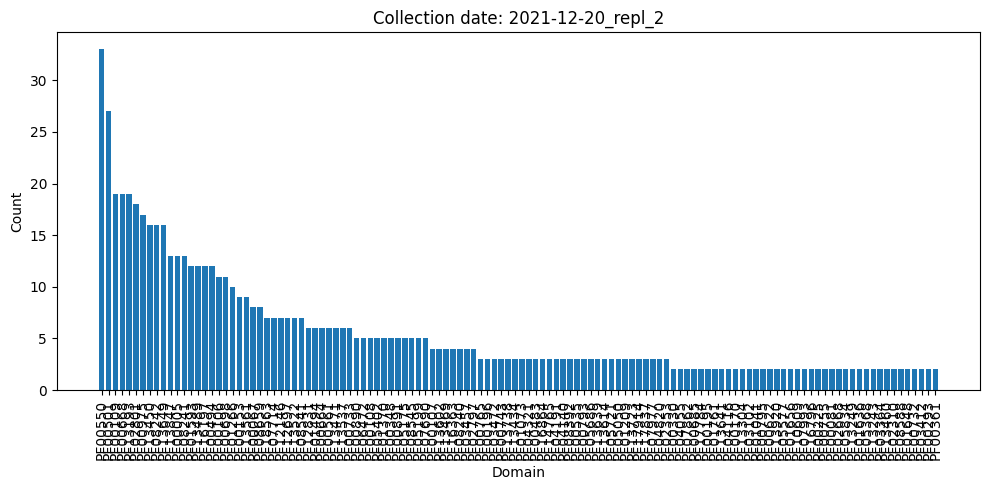

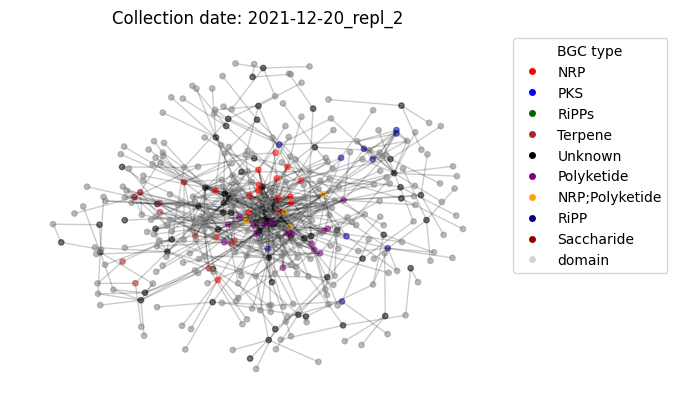

In [450]:
## water tables ordered
ALL_COUNTS_sediment = {}
all_ids_sediment = []
for item in sediment_tables:
    collection_date = create_graph_id(item[2])
    all_ids_sediment.append(collection_date)

    nodes, nodes_domains, edges = graph_nodes_edges(tables[item[2]], color_hash)
    G = generate_graph(nodes, nodes_domains, edges, collection_date)
    cnt_full, cnt_multiple = count_multiple_edges(edges)

    ALL_COUNTS_sediment[item[2]] = (cnt_full, cnt_multiple)

    plot_domain_edges_counts(cnt_multiple, f"Collection date: {G.graph['date']}")
    plot_graph(G, color_hash)

### Plot counts over time

In [451]:
# from ALL_COUNTS retrieve
from collections import defaultdict

counts_evolution = defaultdict(lambda: [0]*len(ALL_COUNTS_sediment.keys()))
for i, key in enumerate(ALL_COUNTS_sediment.keys()):
    cnt_full = ALL_COUNTS_sediment[key][0]
    for k, v in cnt_full.items():
        counts_evolution[k][i] = v

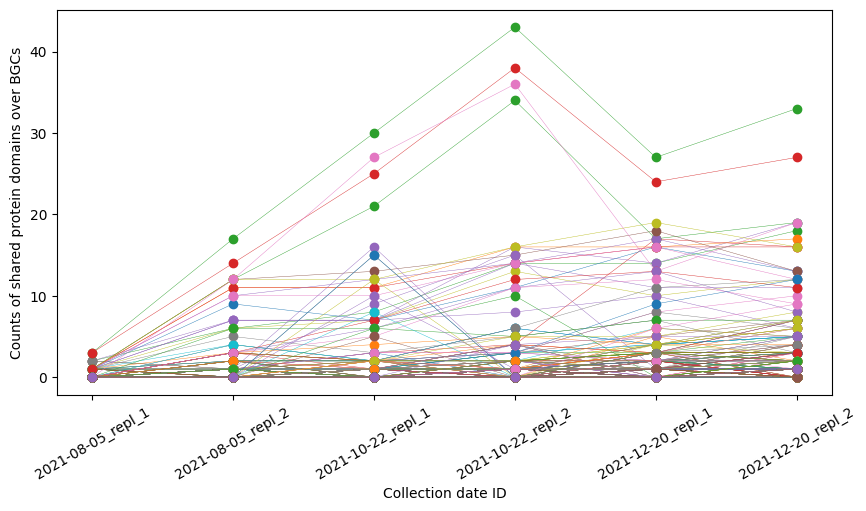

In [452]:
# plot counts evolution
plt.figure(figsize=(10, 5))
for i in counts_evolution.keys():
    plt.plot(counts_evolution[i], '-o', linewidth=0.3, label=i)

plt.xticks(range(len(all_ids_sediment)), all_ids_sediment, rotation=30)
plt.xlabel('Collection date ID')
plt.ylabel('Counts of shared protein domains over BGCs')
plt.show()

## Loop over all

Number of nodes: 65
Number of nodes from domains: 137
Number of edges: 481
Number of nodes: 202
Number of edges: 481


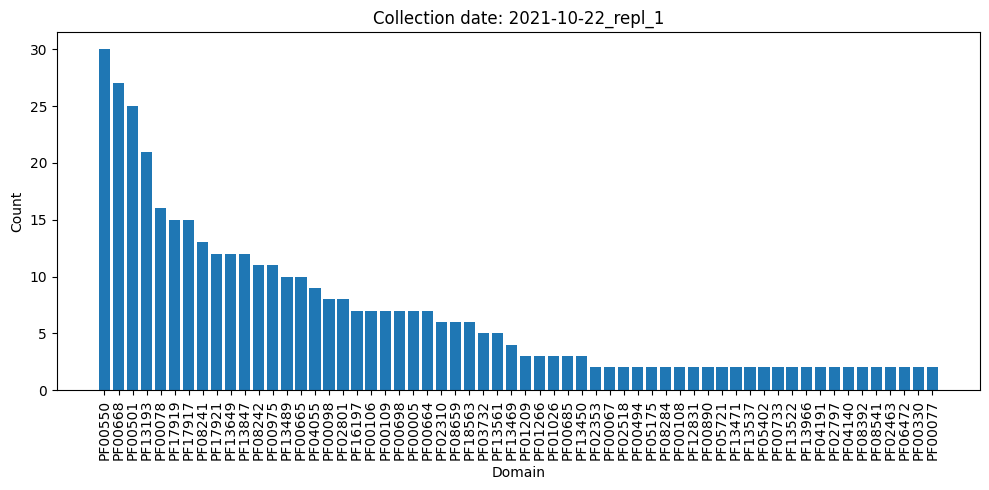

Time taken: 0.2610793113708496 seconds


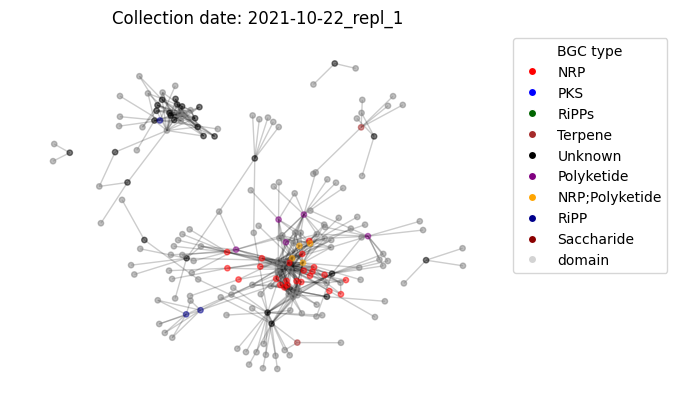

Number of nodes: 72
Number of nodes from domains: 183
Number of edges: 634
Number of nodes: 255
Number of edges: 634


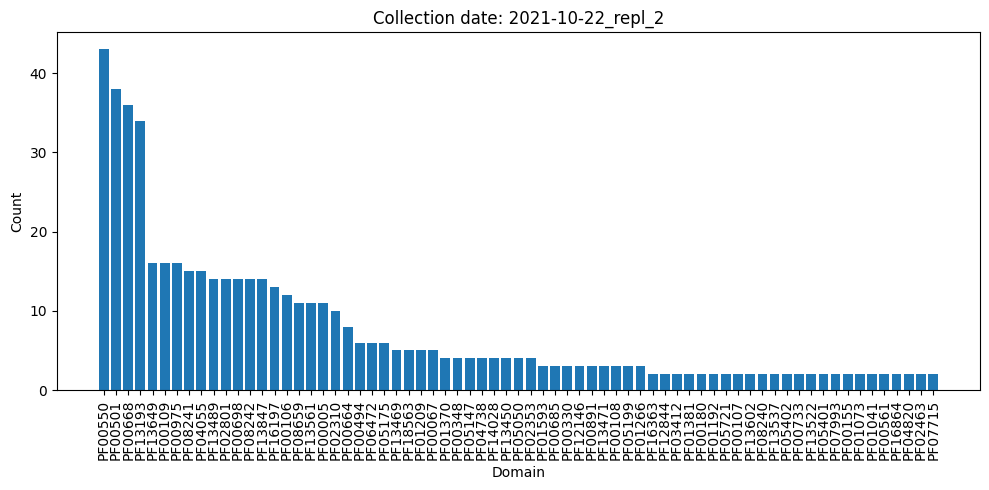

Time taken: 0.45322299003601074 seconds


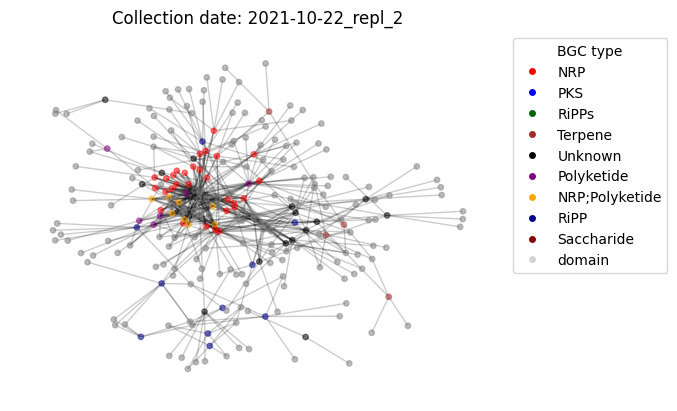

Number of nodes: 96
Number of nodes from domains: 264
Number of edges: 753
Number of nodes: 360
Number of edges: 753


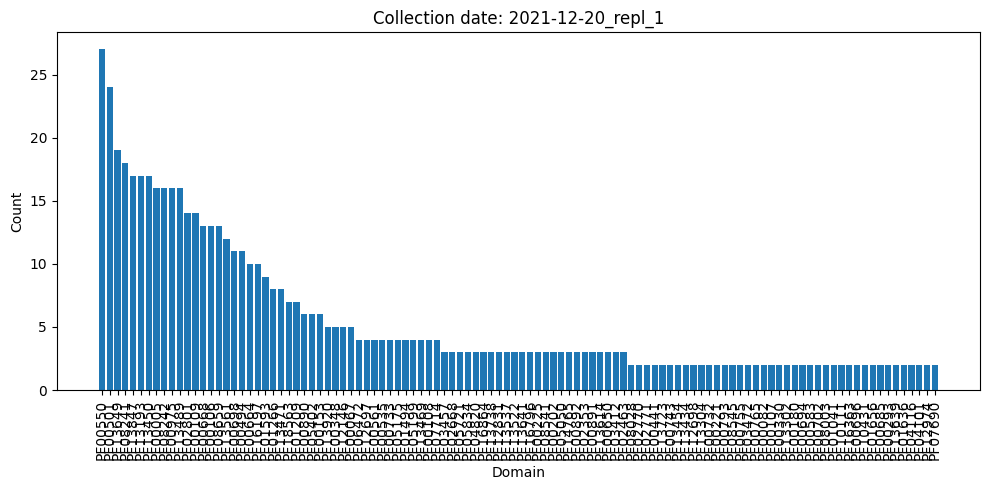

Time taken: 0.6004116535186768 seconds


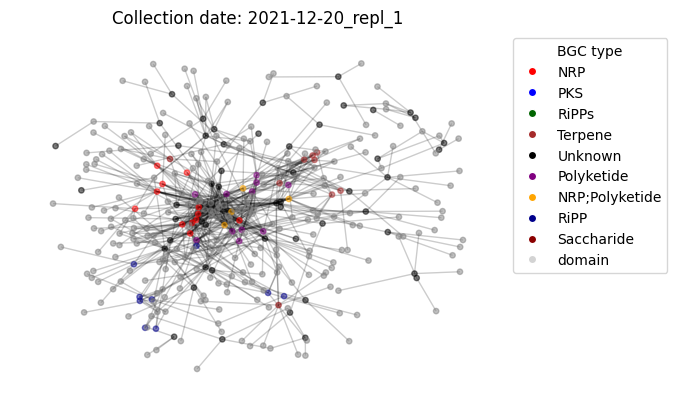

Number of nodes: 116
Number of nodes from domains: 275
Number of edges: 835
Number of nodes: 391
Number of edges: 835


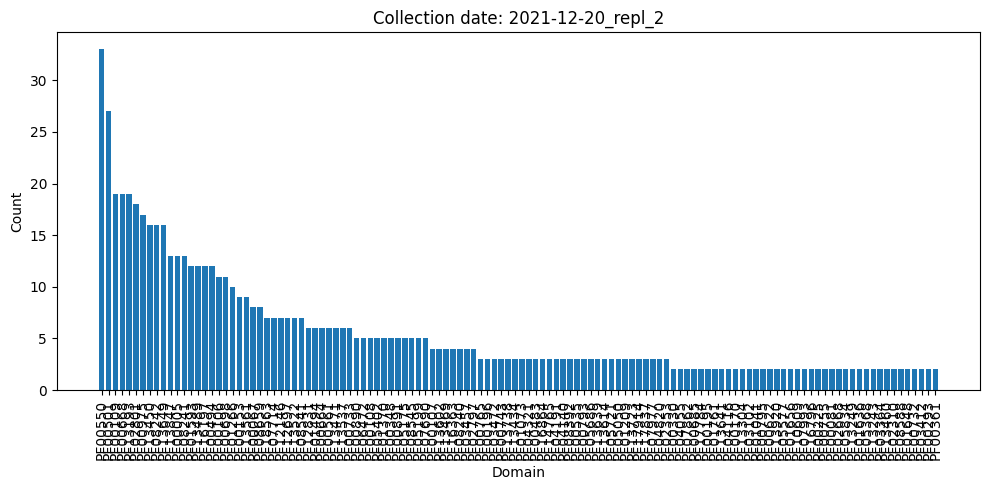

Time taken: 0.7919187545776367 seconds


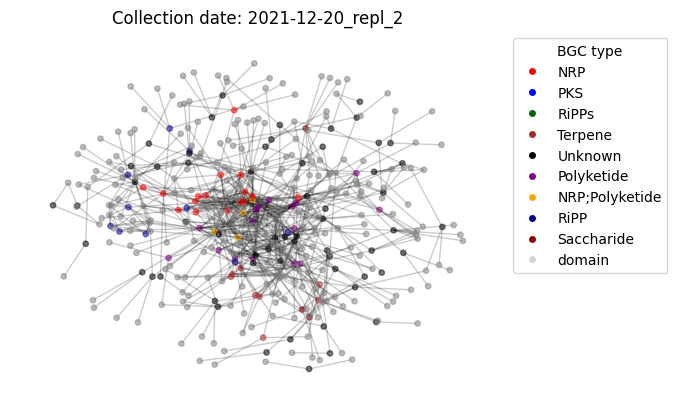

Number of nodes: 83
Number of nodes from domains: 206
Number of edges: 520
Number of nodes: 289
Number of edges: 520


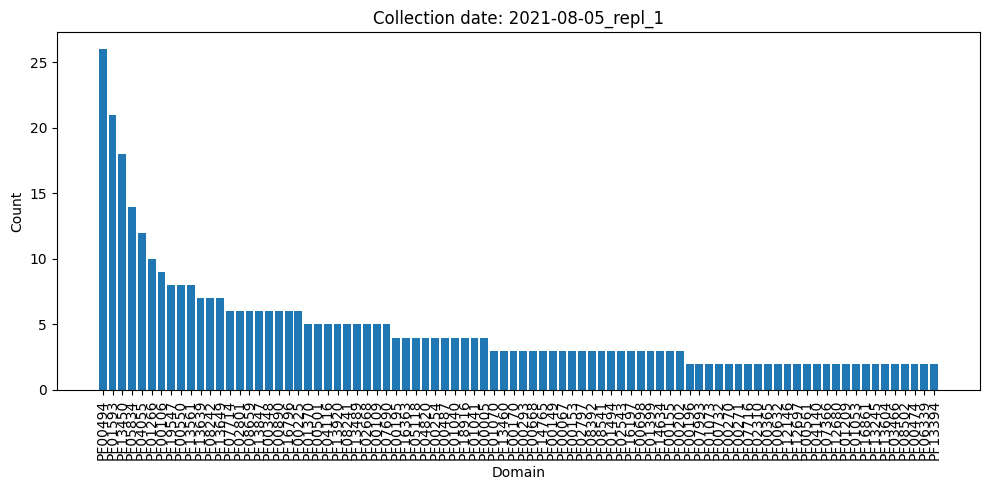

Time taken: 0.7613880634307861 seconds


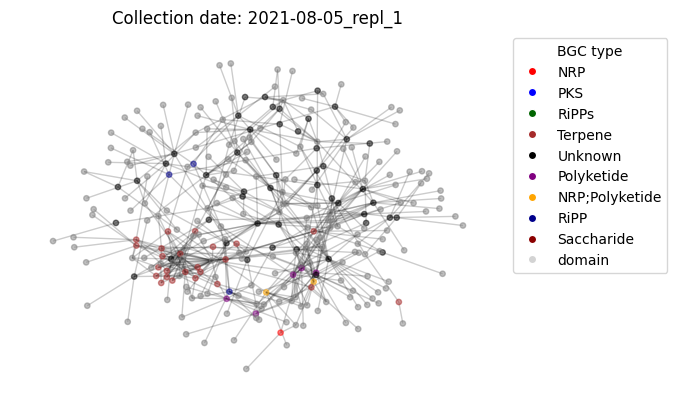

Number of nodes: 8
Number of nodes from domains: 44
Number of edges: 52
Number of nodes: 52
Number of edges: 52


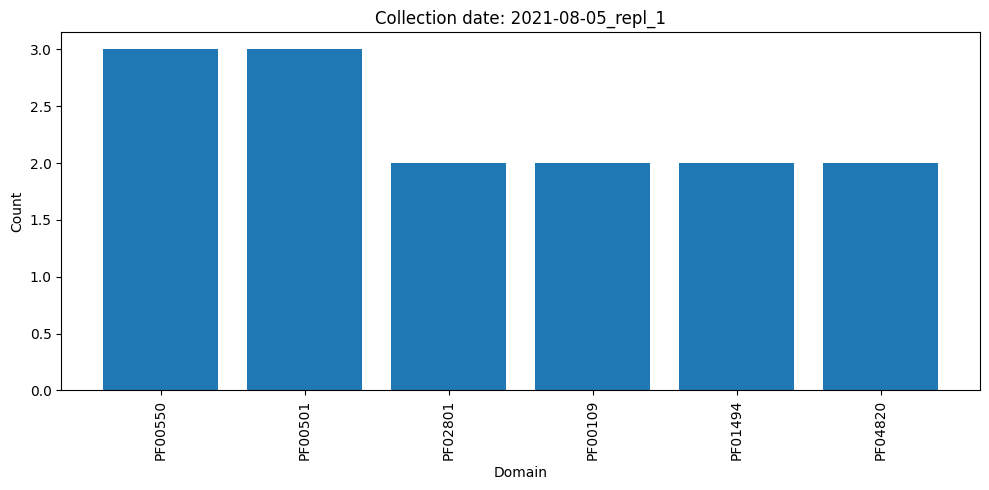

Time taken: 0.4208979606628418 seconds


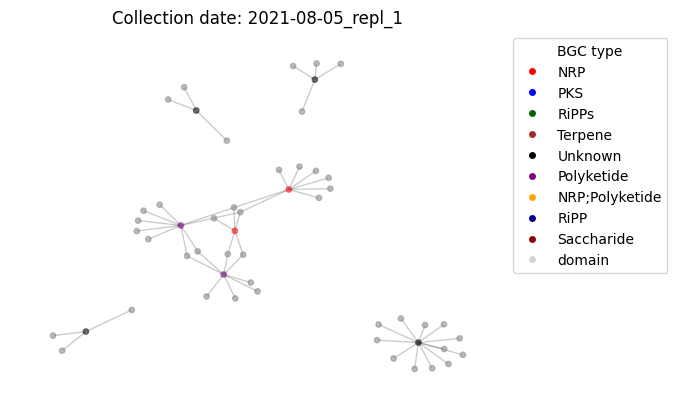

Number of nodes: 75
Number of nodes from domains: 194
Number of edges: 411
Number of nodes: 269
Number of edges: 411


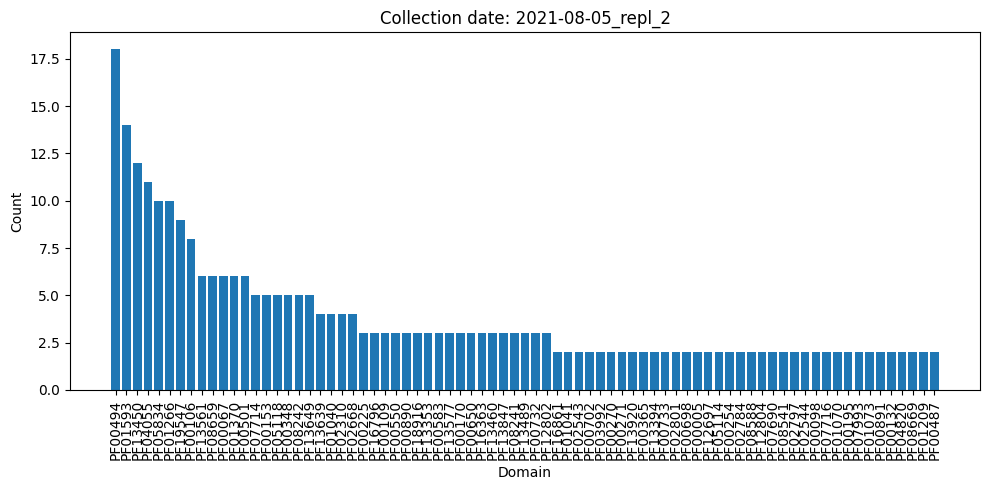

Time taken: 0.4252161979675293 seconds


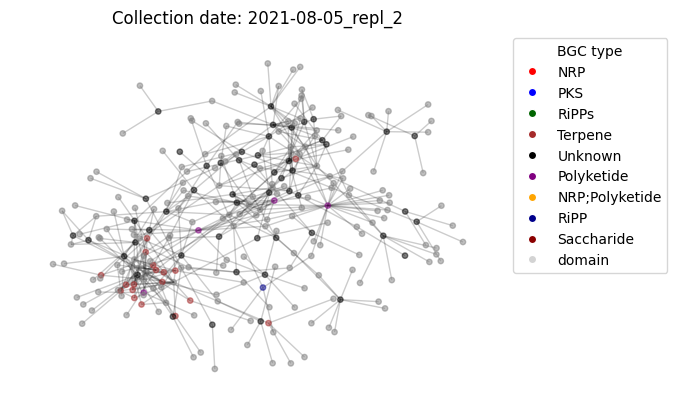

Number of nodes: 38
Number of nodes from domains: 139
Number of edges: 339
Number of nodes: 177
Number of edges: 339


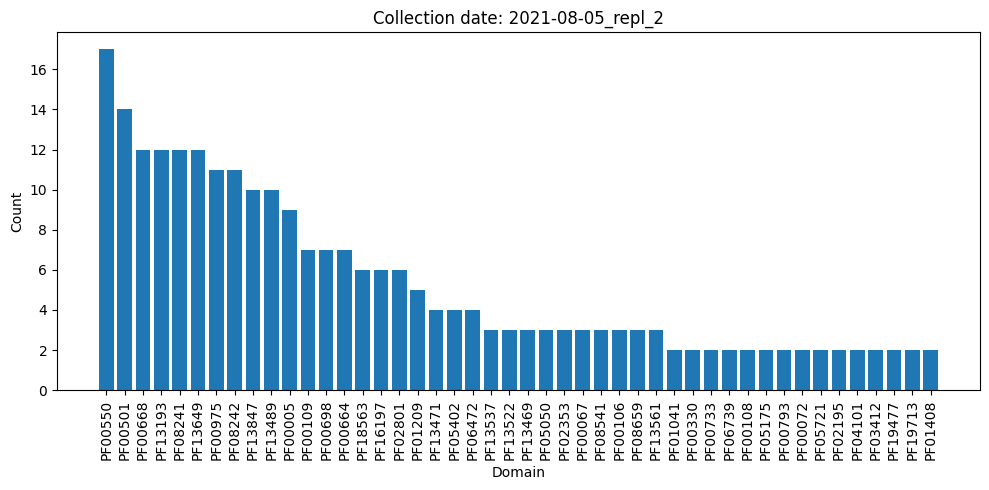

Time taken: 0.46579694747924805 seconds


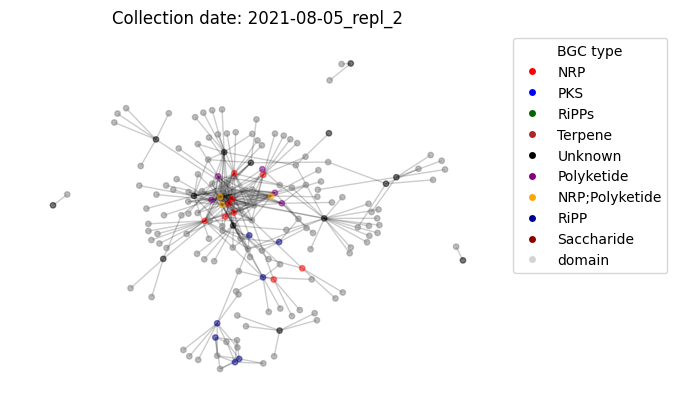

Number of nodes: 41
Number of nodes from domains: 110
Number of edges: 267
Number of nodes: 151
Number of edges: 267


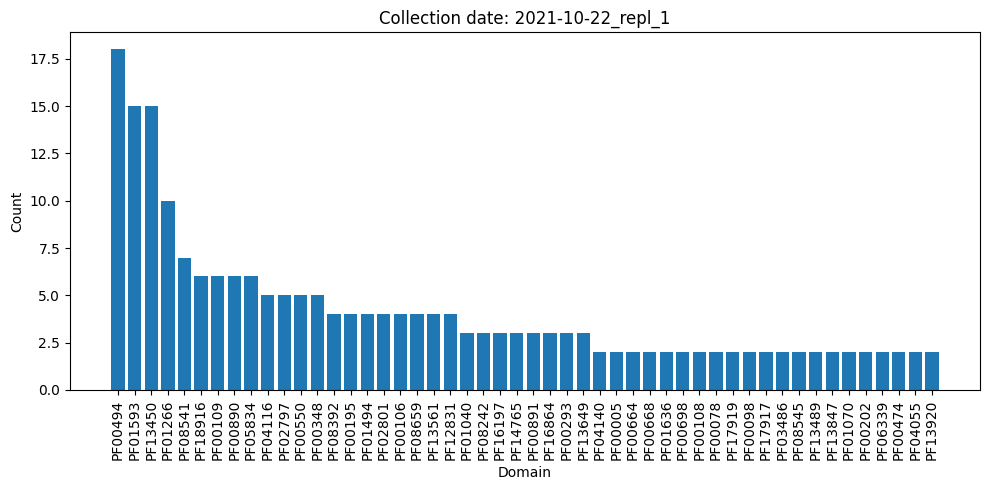

Time taken: 0.3971214294433594 seconds


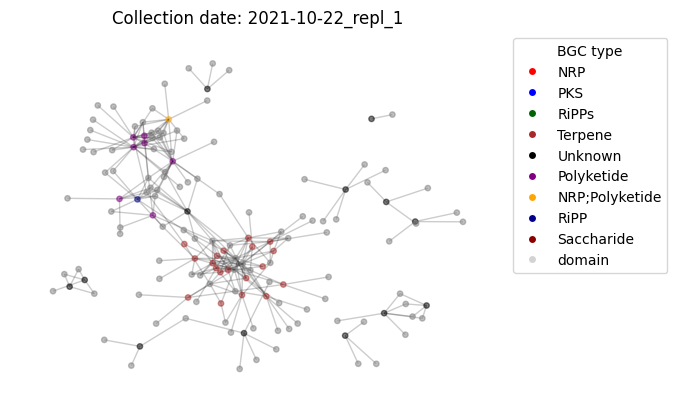

Number of nodes: 58
Number of nodes from domains: 142
Number of edges: 355
Number of nodes: 200
Number of edges: 355


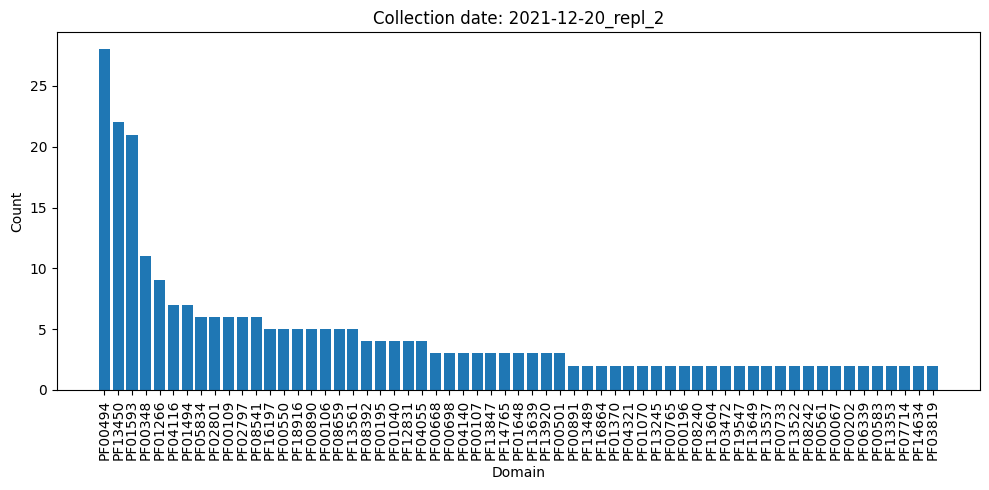

Time taken: 0.3890819549560547 seconds


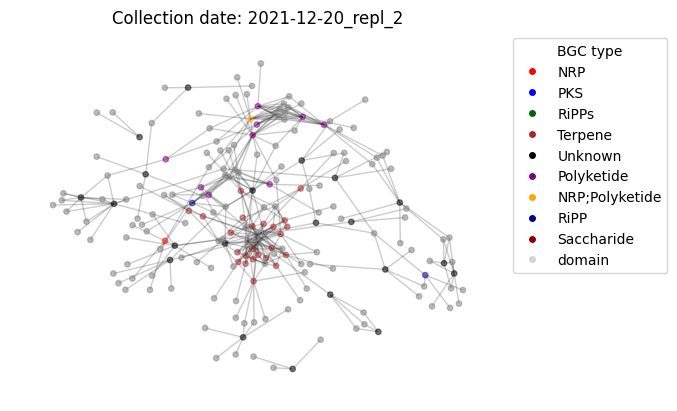

Number of nodes: 90
Number of nodes from domains: 186
Number of edges: 592
Number of nodes: 276
Number of edges: 592


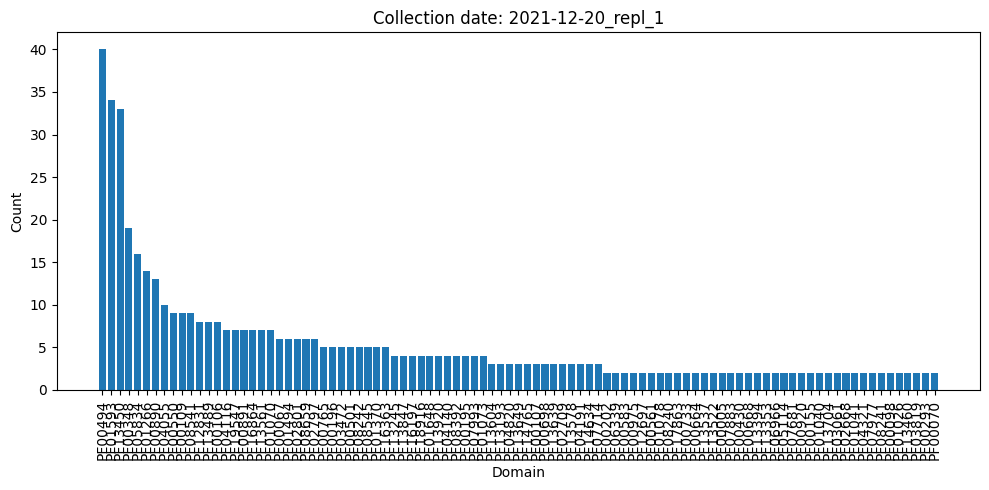

Time taken: 0.5768234729766846 seconds


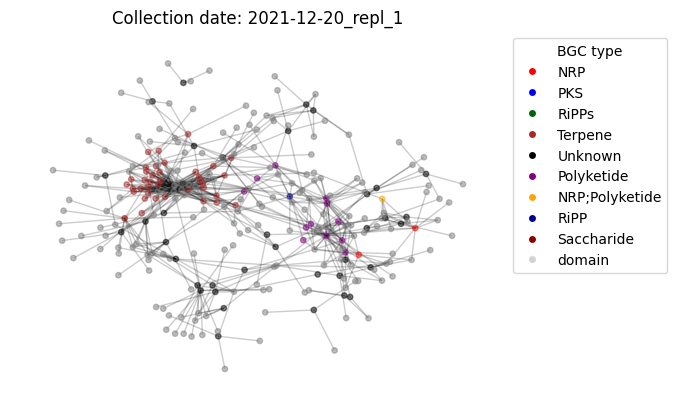

Number of nodes: 103
Number of nodes from domains: 200
Number of edges: 675
Number of nodes: 303
Number of edges: 675


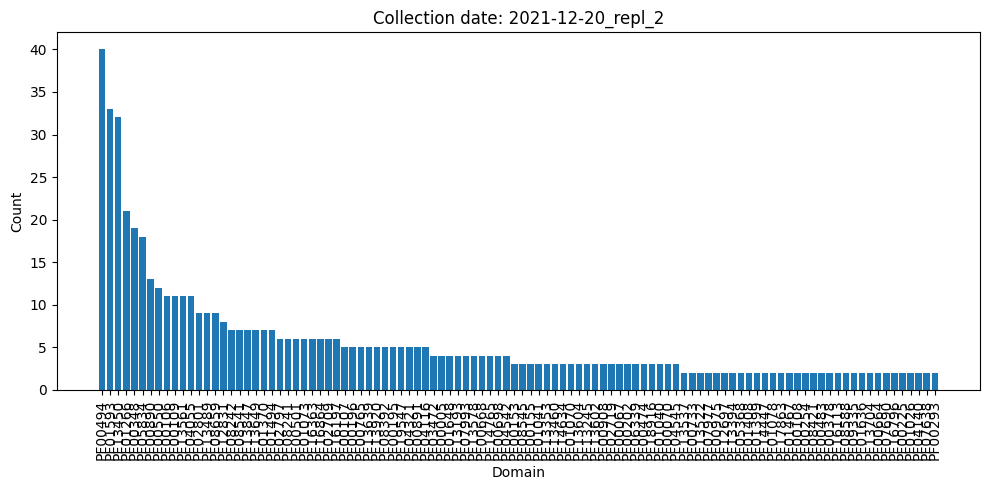

Time taken: 0.6394095420837402 seconds


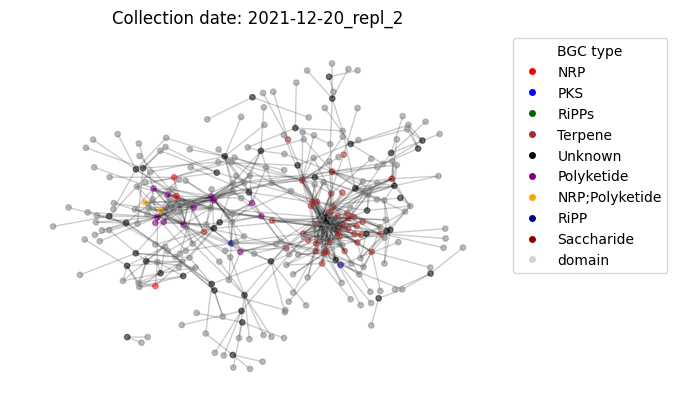

Number of nodes: 35
Number of nodes from domains: 91
Number of edges: 240
Number of nodes: 126
Number of edges: 240


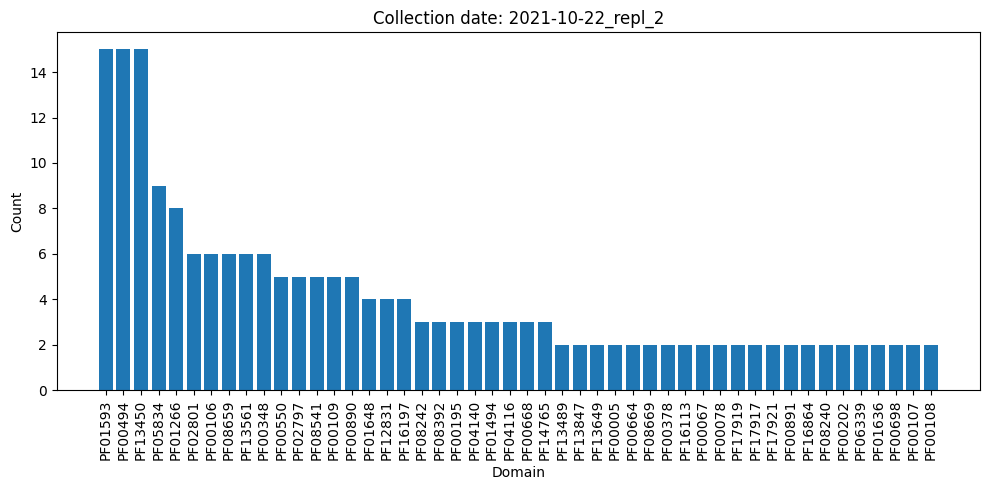

Time taken: 1.0609853267669678 seconds


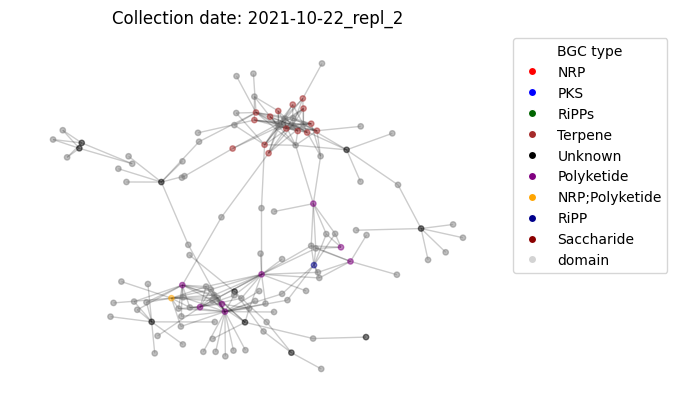

Number of nodes: 92
Number of nodes from domains: 222
Number of edges: 626
Number of nodes: 314
Number of edges: 626


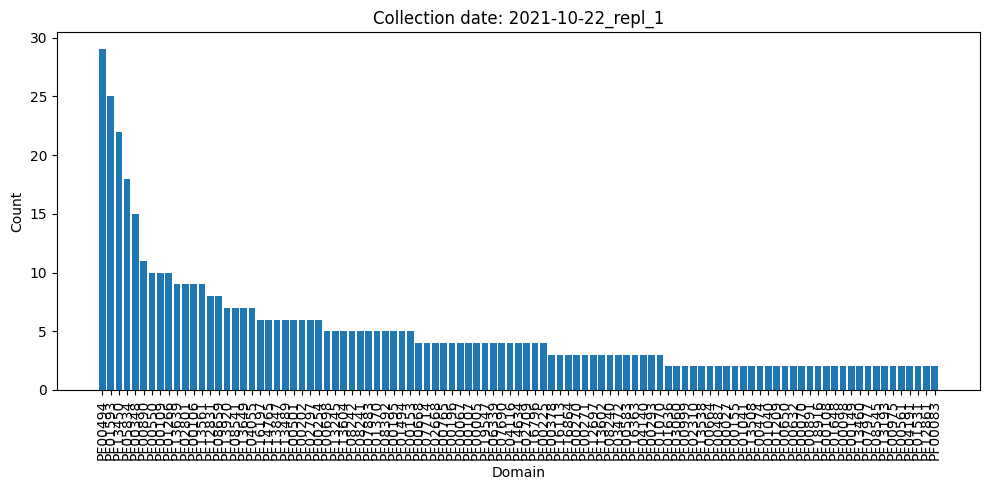

Time taken: 0.5122988224029541 seconds


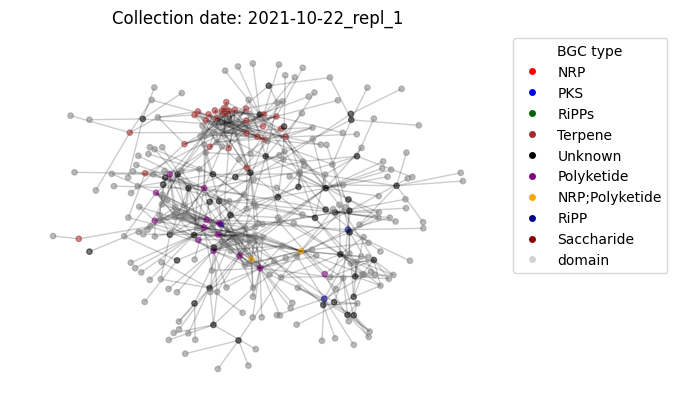

Number of nodes: 74
Number of nodes from domains: 189
Number of edges: 438
Number of nodes: 263
Number of edges: 438


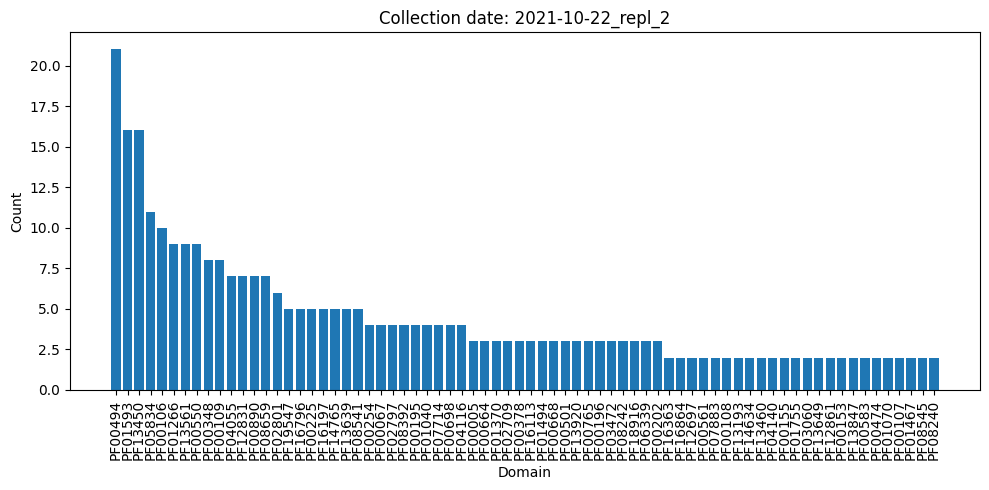

Time taken: 0.6150708198547363 seconds


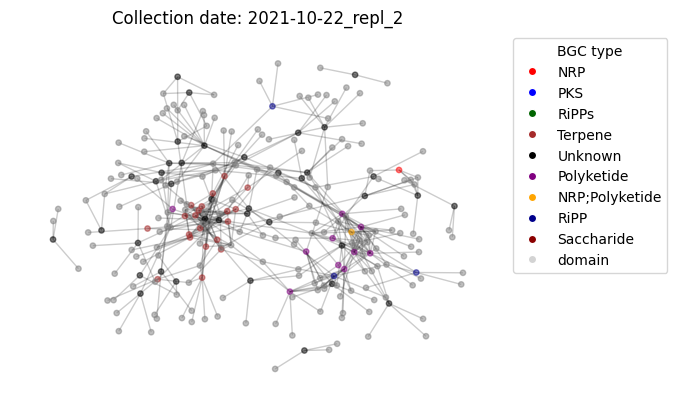

Number of nodes: 37
Number of nodes from domains: 107
Number of edges: 248
Number of nodes: 144
Number of edges: 248


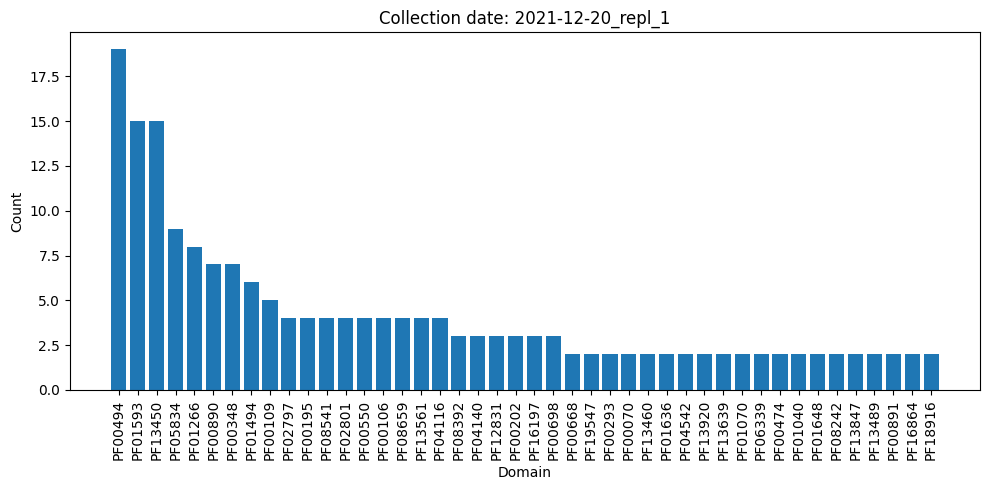

Time taken: 0.48276257514953613 seconds


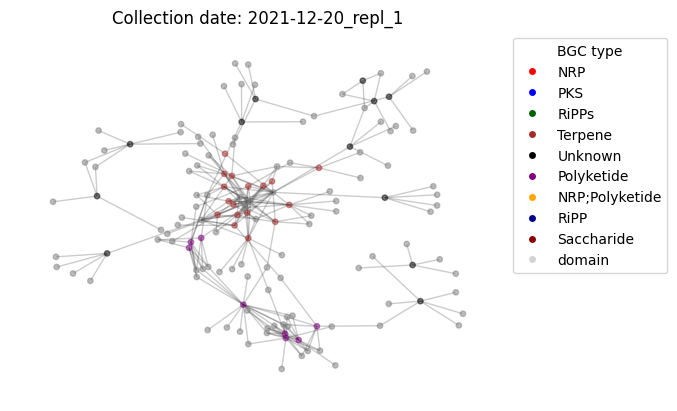

In [409]:
# run loop over all tables
import time
start = time.time()

ALL_COUNTS = {}
all_collection_dates = []
for i, (name, df) in enumerate(tables.items()):
    nodes, nodes_domains, edges = graph_nodes_edges(df, color_hash)

    collection_date = create_graph_id(name)
    all_collection_dates.append(collection_date)
    G = generate_graph(nodes, nodes_domains, edges, collection_date)
    cnt_full, cnt_multiple = count_multiple_edges(edges)

    ALL_COUNTS[name] = (cnt_full, cnt_multiple)

    plot_domain_edges_counts(cnt_multiple, f"Collection date: {G.graph['date']}")
    print(f"Time taken: {time.time() - start} seconds")
    start = time.time()
    plot_graph(G, color_hash)


In [410]:
# from ALL_COUNTS retrieve
from collections import defaultdict

counts_evolution = defaultdict(lambda: [0]*len(ALL_COUNTS.keys()))
for i, key in enumerate(ALL_COUNTS.keys()):
    cnt_full = ALL_COUNTS[key][0]
    for k, v in cnt_full.items():
        counts_evolution[k][i] = v

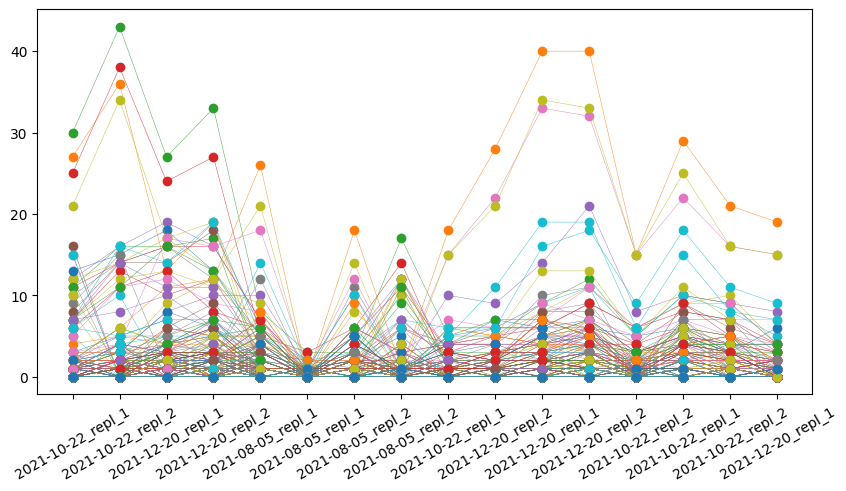

In [411]:
# plot counts evolution
plt.figure(figsize=(10, 5))
for i in counts_evolution.keys():
    plt.plot(counts_evolution[i], '-o', linewidth=0.3, label=i)

plt.xticks(range(len(all_collection_dates)), all_collection_dates, rotation=30)
plt.show()

## Content setup

### DF display

In [ ]:
pn.extension("tabulator", "mathjax")
DATASETS = {}
ACCENT = "teal"

styles = {
    "box-shadow": "rgba(50, 50, 93, 0.25) 0px 6px 12px -2px, rgba(0, 0, 0, 0.3) 0px 3px 7px -3px",
    "border-radius": "4px",
    "padding": "10px",
}

image = pn.pane.JPG(os.path.join(assets_folder, "figs/logo_gecco.jpeg"),
                    width=100, height=100)

markdown_intro = pn.pane.Markdown(
"""
**If you want to use the Galaxy API:**
- you need to provide your credentials.
- and `job_id` of the job that created the files to get those files.
- For comparison study, you need to provide two job_ids.
"""
)

md_upload = pn.pane.Markdown(
"""
**Upload your files:**
You need to select exactly 3 files where filenames contain:
- `BGCs`
- `features`
- `genes`
"""
)

md_get_galaxy = pn.pane.Markdown(
"""
**Get files from Galaxy:**
You need to provide your credentials and `job_id`.
"""
)

upload_local = pn.widgets.FileInput(
    multiple=True,
)

literal_galaxy_url = pn.widgets.TextInput(
    name='Galaxy server URL',
    placeholder='Enter a https server address here...',
)

literal_galaxy_key = pn.widgets.PasswordInput(
    name='Password',
    placeholder='Enter your password here...',
)

button_display_loaded = pn.widgets.Button(
    name="Display loaded files",
    button_type="primary",
    width=200,
)

### Analysis page

In [ ]:
bgc_types = pn.pane.Matplotlib(
    height=600,
    name="BGC types",
    )

analysis_tab = pn.Column(
    bgc_types,
)

tabs = pn.Tabs(
    ('BGCs',""),
    ('features', ""),
    ('genes', ""),
    ("Analysis", analysis_tab),
    dynamic=True,
    styles=styles,
    sizing_mode="stretch_height",
    margin=10,
)


### update methods

In [ ]:
def display_tables_after_upload(datasets):
    logger.info("Displaying tables after upload...")
    tabs.__setitem__(0,
                     pn.widgets.Tabulator(
                        datasets[next((key for key in datasets if 'BGCs' in key))],
                        name='BGCs',
                        page_size=50,
                    ),
                    )
    tabs.__setitem__(1,
                     pn.widgets.Tabulator(
                        datasets[next((key for key in datasets if 'features' in key))],
                        name='features',
                        page_size=50,
                    ),
                    )
    tabs.__setitem__(2,
                     pn.widgets.Tabulator(
                        datasets[next((key for key in datasets if 'genes' in key))],
                        name='genes',
                        page_size=50,
                    ),
                    )


def process_uploaded_tables(file_names, file_data):
    """
    Process the uploaded tables and display them in a tabular format.
    """
    logger.info("Processing uploaded tables...")
    logger.info(f"files: {file_names}")
    DATASETS.clear()
    if file_names is []:
        return
    for i, name in enumerate(file_names):
        DATASETS[name] = bytes_to_df(file_data[i])
    # Display the first table
    display_tables_after_upload(DATASETS)
    update_bgs_types_plot()


def update_bgs_types_plot():
    """
    Update the BGC types plot.
    """
    logger.info("Updating BGC types plot...")
    bgc_types.object = pl.mpl_bgcs_violin(DATASETS[next((key for key in DATASETS if 'BGCs' in key))])

### Bindings

In [ ]:

pn.bind(
    process_uploaded_tables,
    file_names=upload_local.filename,
    file_data = upload_local.value,
    watch=True,
)

button_display_loaded.on_click(
    lambda event: process_uploaded_tables(upload_local.filename, upload_local.value)
)

## APP setup

In [ ]:
pn.extension("tabulator", "mathjax")

def app():
    template = pn.template.FastListTemplate(
        title="DBiosynthetic Gene Cluster Analysis",
        sidebar=[image,
                md_upload, 
                pn.Row(upload_local),
                pn.layout.Divider(margin=(-20, 0, 0, 0)),
                md_get_galaxy, literal_galaxy_url, literal_galaxy_key,
                button_display_loaded,
                ],
        main=[pn.Column(markdown_intro,
                        pn.layout.Divider(margin=(-20, 0, 0, 0)),
                        tabs,
                        scroll=True,
                    )],
        main_layout=None,
        accent=ACCENT,
    )
    return template

template = app()


if 'google.colab' in str(get_ipython()):  
    s = serve_app(template, env=env, name="GECCO_analyser")
else:
    template.servable()

### Uncomment this if running if running ngrok tunnel which you want to quit

In [ ]:
# only use for the ngrok tunnel in GColab
# close_server(s, env=env)